In [3]:
!pip3 install --upgrade google-cloud
!pip3 install --upgrade google-cloud-bigquery
!pip3 install --upgrade google-cloud-storage
!pip3 install db-dtypes
!pip3 install 'google-cloud-bigquery[pandas]'
!pip3 install numpy
!pip3 install pandas
!pip3 install google.cloud
!pip3 install scipy
!pip3 install plotly
!pip3 install seaborn

  Using cached google_cloud_storage-2.17.0-py2.py3-none-any.whl.metadata (6.6 kB)
Using cached google_cloud_storage-2.17.0-py2.py3-none-any.whl (126 kB)


In [1]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import db_dtypes

In [69]:
def impressions_completeness(start_date, end_date):

    impression_completeness = """
            with impression_data as (
            SELECT 
                session_key
                ,eventAction
                ,eventTimestamp
                ,COALESCE(global_entity_id,json_value(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,hitMatchId AS perseus_hit_match_id
                ,COALESCE(shopListType,json_value(eventVariables_json, "$.shopListType") ) AS shopListType
                ,COALESCE(shopId,json_value(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(shopPosition,json_value(eventVariables_json, "$.shopPosition") ) AS shopPosition
                ,COALESCE(eventOrigin,json_value(eventVariables_json, "$.origin") ) AS eventOrigin
                ,json_value(eventVariables_json, "$.shopRatingQuality")  AS shopRatingQuality
                ,json_value(eventVariables_json, "$.businessType")  AS businessType
                ,json_value(eventVariables_json, "$.shopRatingQuantity") AS shopRatingQuantity
                ,json_value(eventVariables_json, "$.shopMinimumOrderValue")  AS shopMinimumOrderValue
                ,coalesce(json_value(eventVariables_json, "$.vendorDeliveryFee"), json_value(eventVariables_json, "$.shopDeliveryFee")) AS vendor_delivery_fee
                ,json_value(eventVariables_json, "$.shopDeliveryTime")  AS shopDeliveryTime
            FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
            WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction = 'shop_impressions.loaded'
            ),
            aggregation as (
            SELECT 
            global_entity_id
            ,count(distinct perseus_session_id) as total_sessions
            ,count(distinct perseus_hit_match_id) as total_hits
            ,count(*) as total_rows
            ,count(distinct case when cast(regexp_extract(vendor_delivery_fee,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as fee_hits
            ,count(distinct case when shopRatingQuality is not null then perseus_hit_match_id end) as quality_hits
            ,count(distinct case when shopRatingQuantity is not null then perseus_hit_match_id end) as quantity_hits
            ,count(distinct case when cast(regexp_extract(shopMinimumOrderValue,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as mov_hits
            ,count(distinct case when shopDeliveryTime is not null then perseus_hit_match_id end) as delivery_time_hits
            ,count(distinct case when businessType is not null then perseus_hit_match_id end) as business_type_hits
            FROM impression_data
            GROUP BY 1
            )
            select a.*,
                1.00 * (fee_hits / total_hits) fee_completeness
                ,1.00 * (quality_hits / total_hits) quality_completeness
                ,1.00 * (quantity_hits / total_hits ) quantity_completeness
                ,1.00 * (mov_hits / total_hits ) mov_completeness
                ,1.00 * (delivery_time_hits / total_hits ) deliverytime_completeness
                ,1.00 * (business_type_hits / total_hits ) bussinesstype_completeness
            from aggregation a
            """

    return impression_completeness



<>:24: SyntaxWarning: invalid escape sequence '\d'
<>:24: SyntaxWarning: invalid escape sequence '\d'
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_2321/3843532852.py:24: SyntaxWarning: invalid escape sequence '\d'
  WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"


/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_2321/601081872.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap

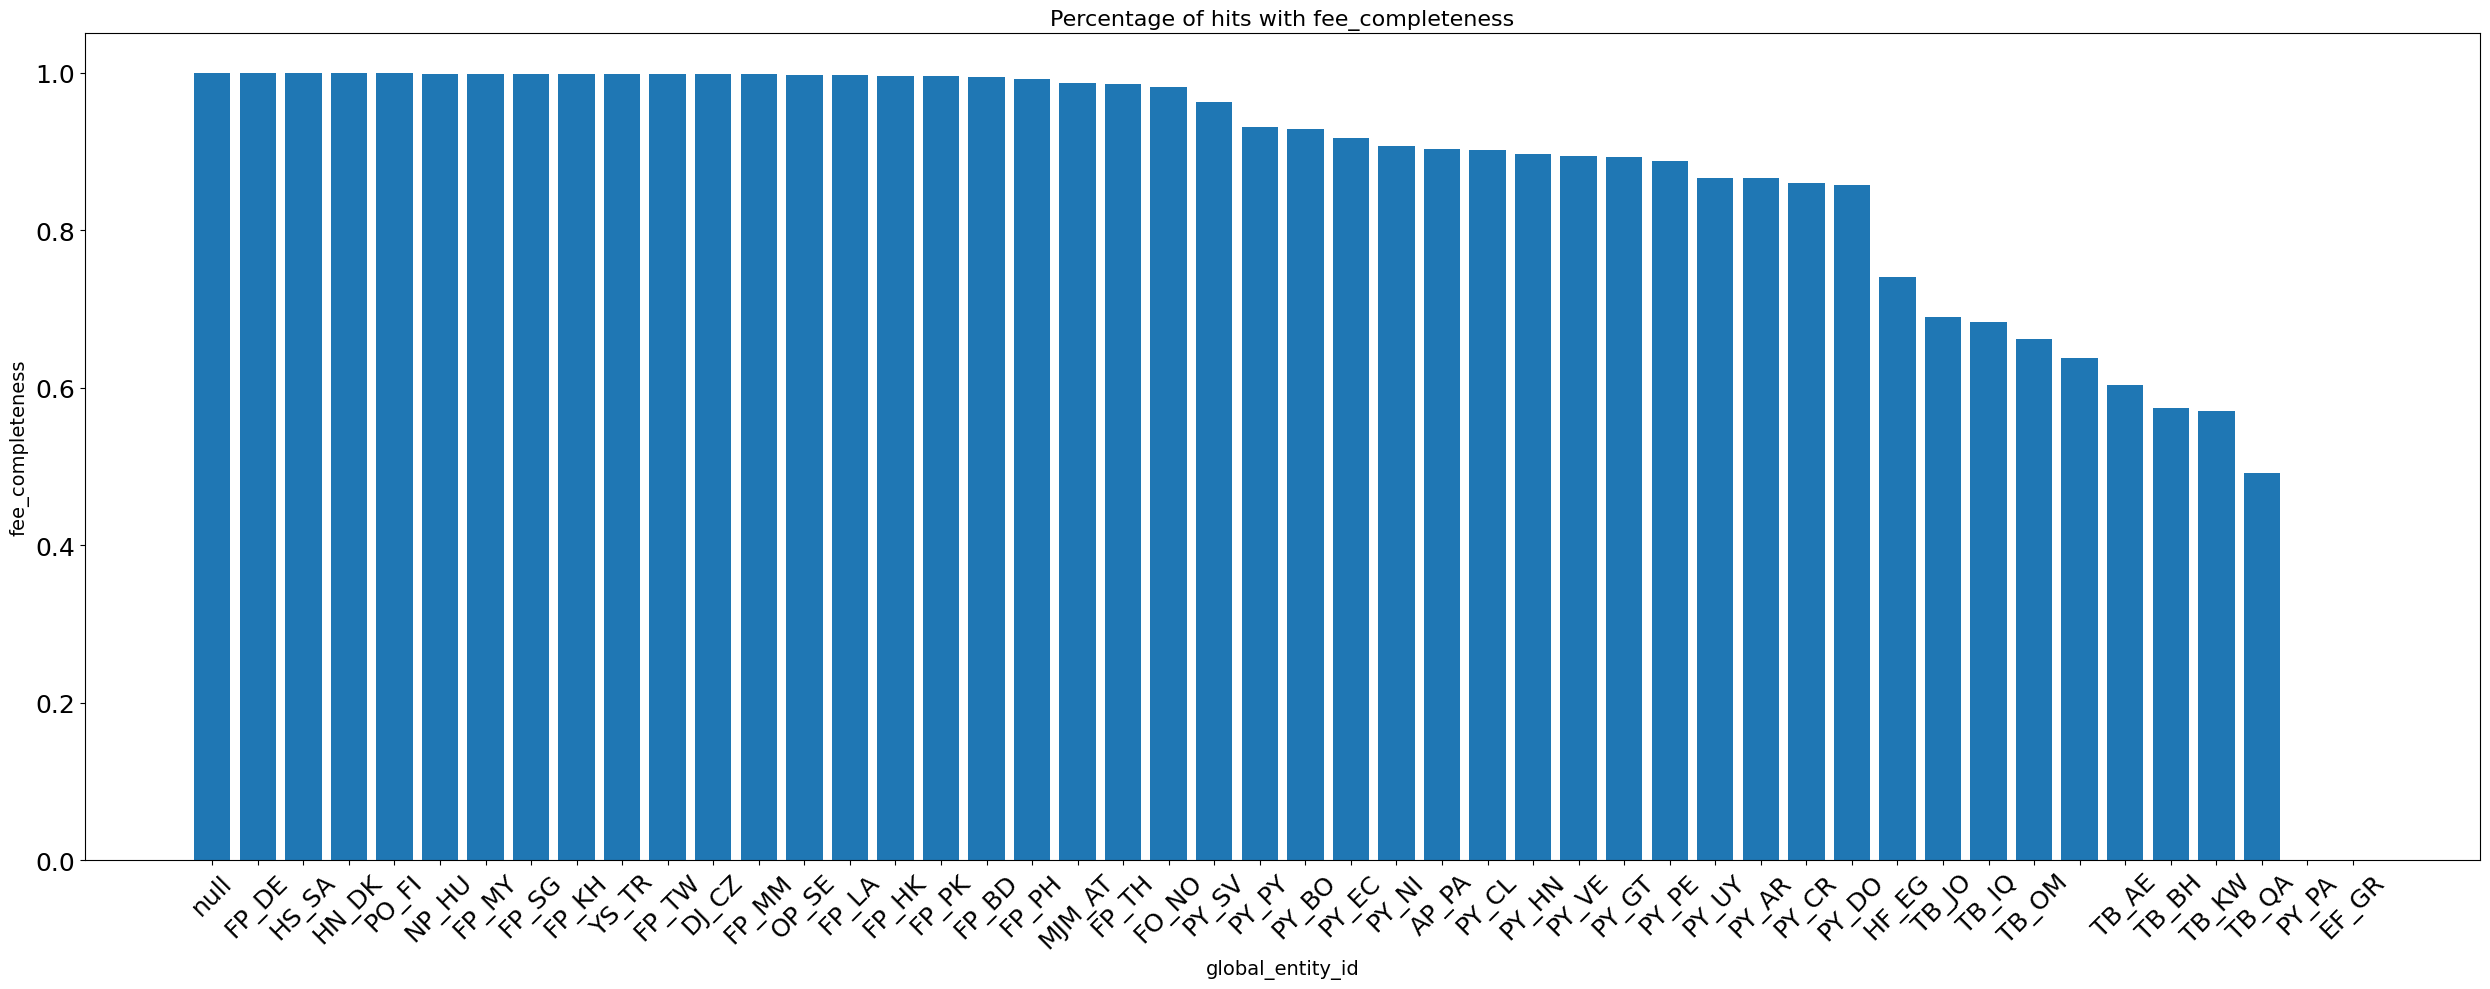

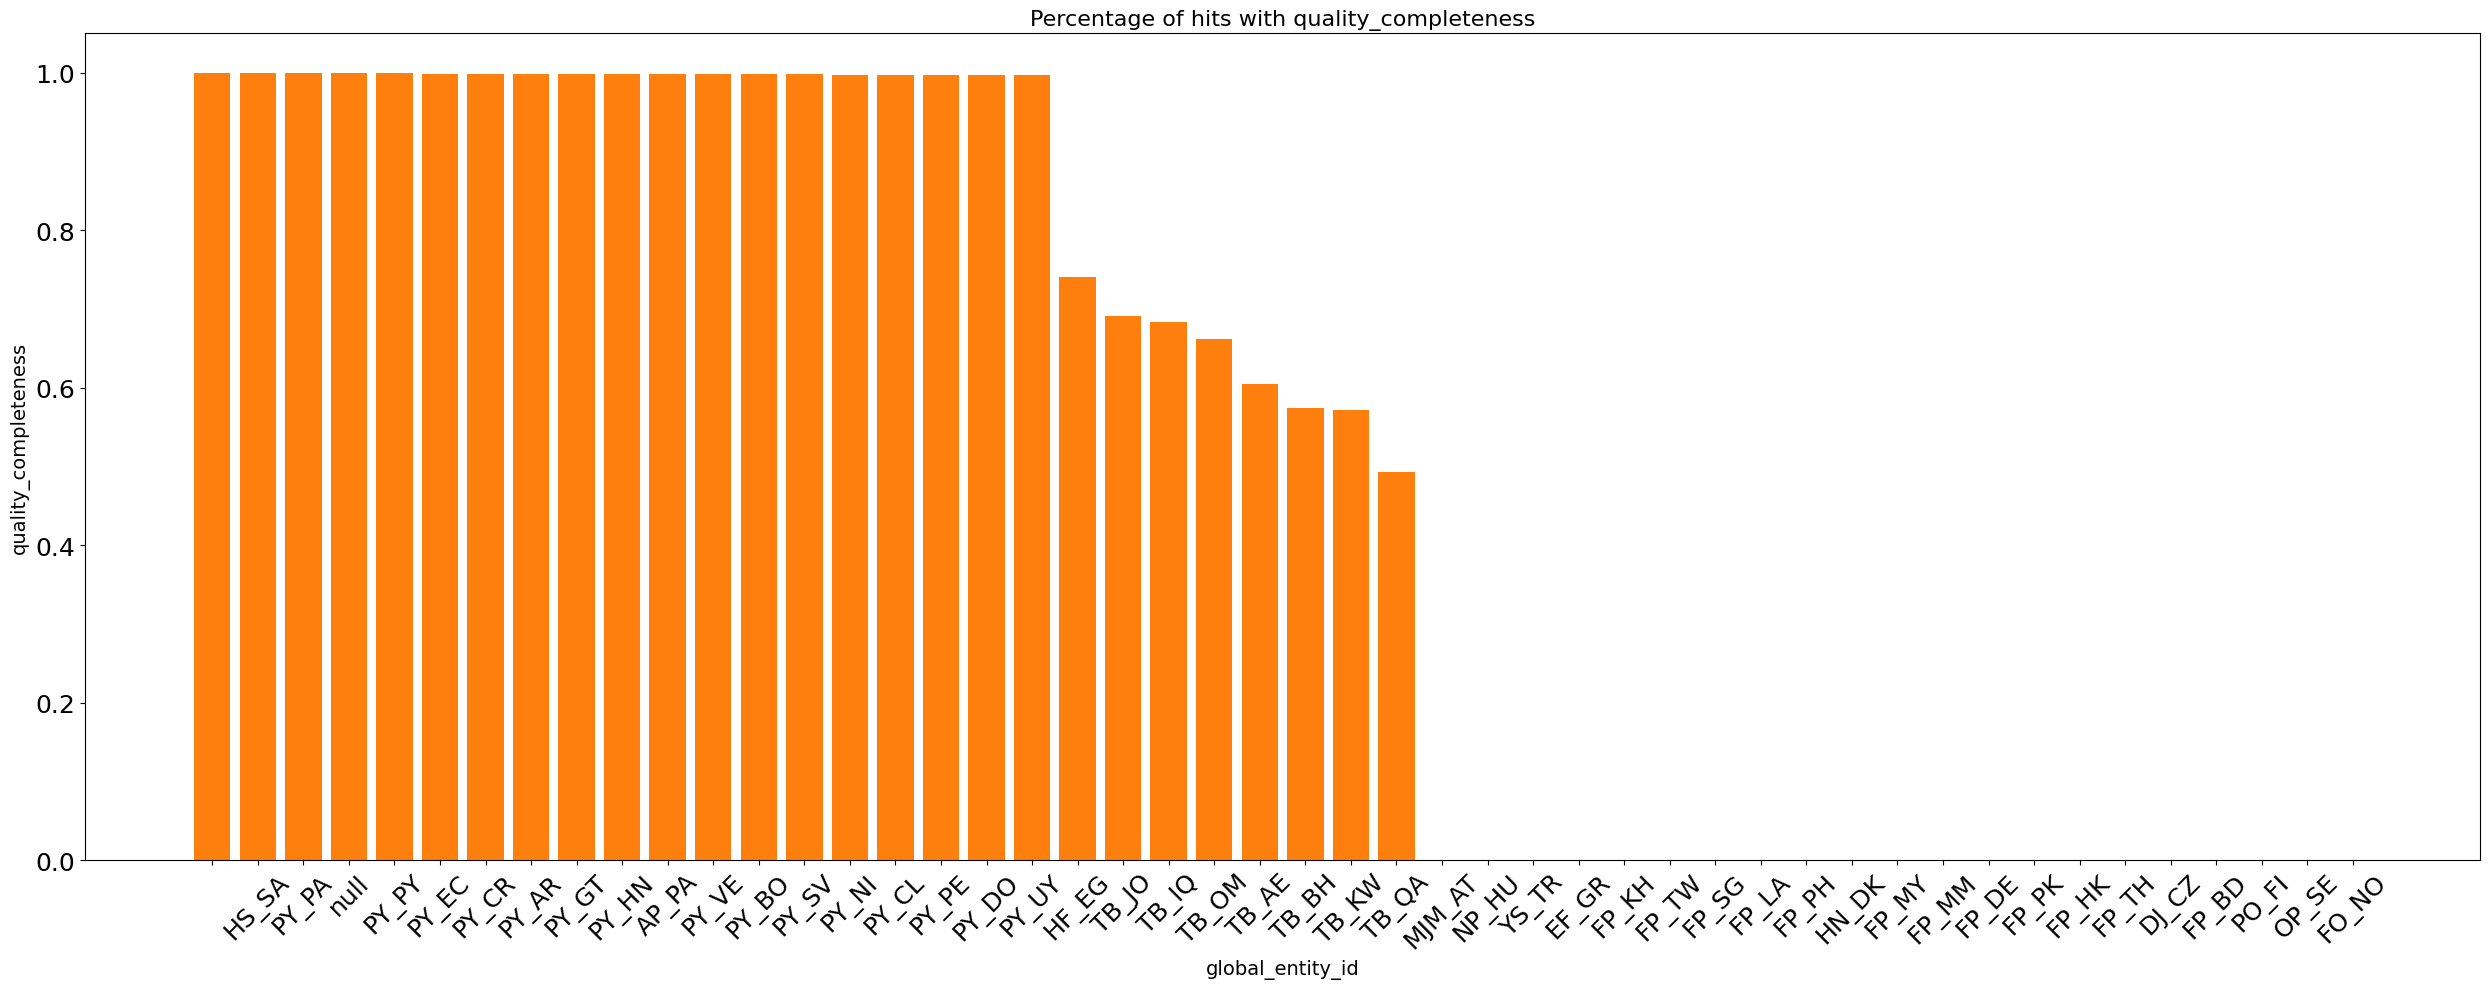

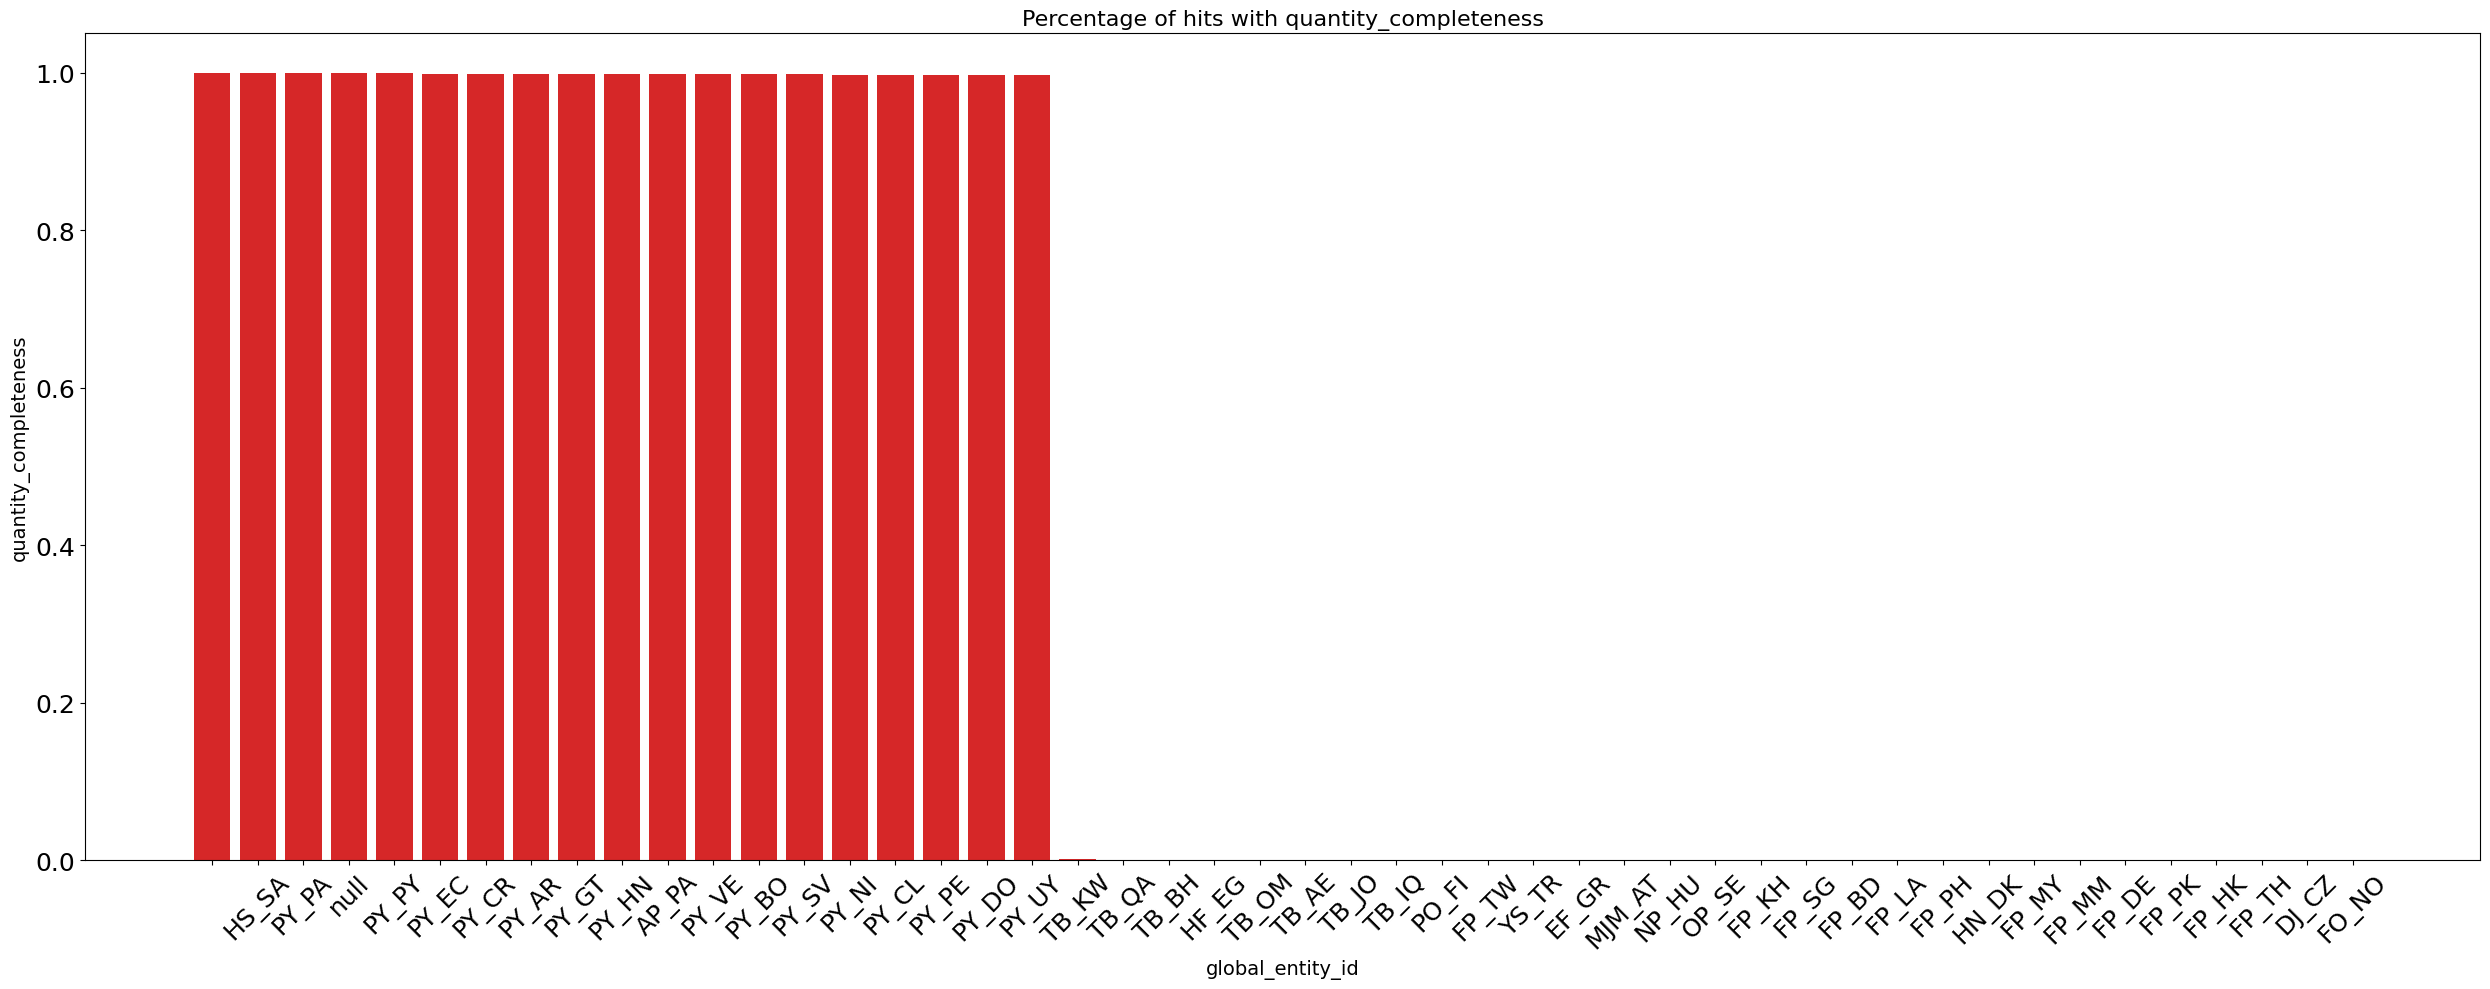

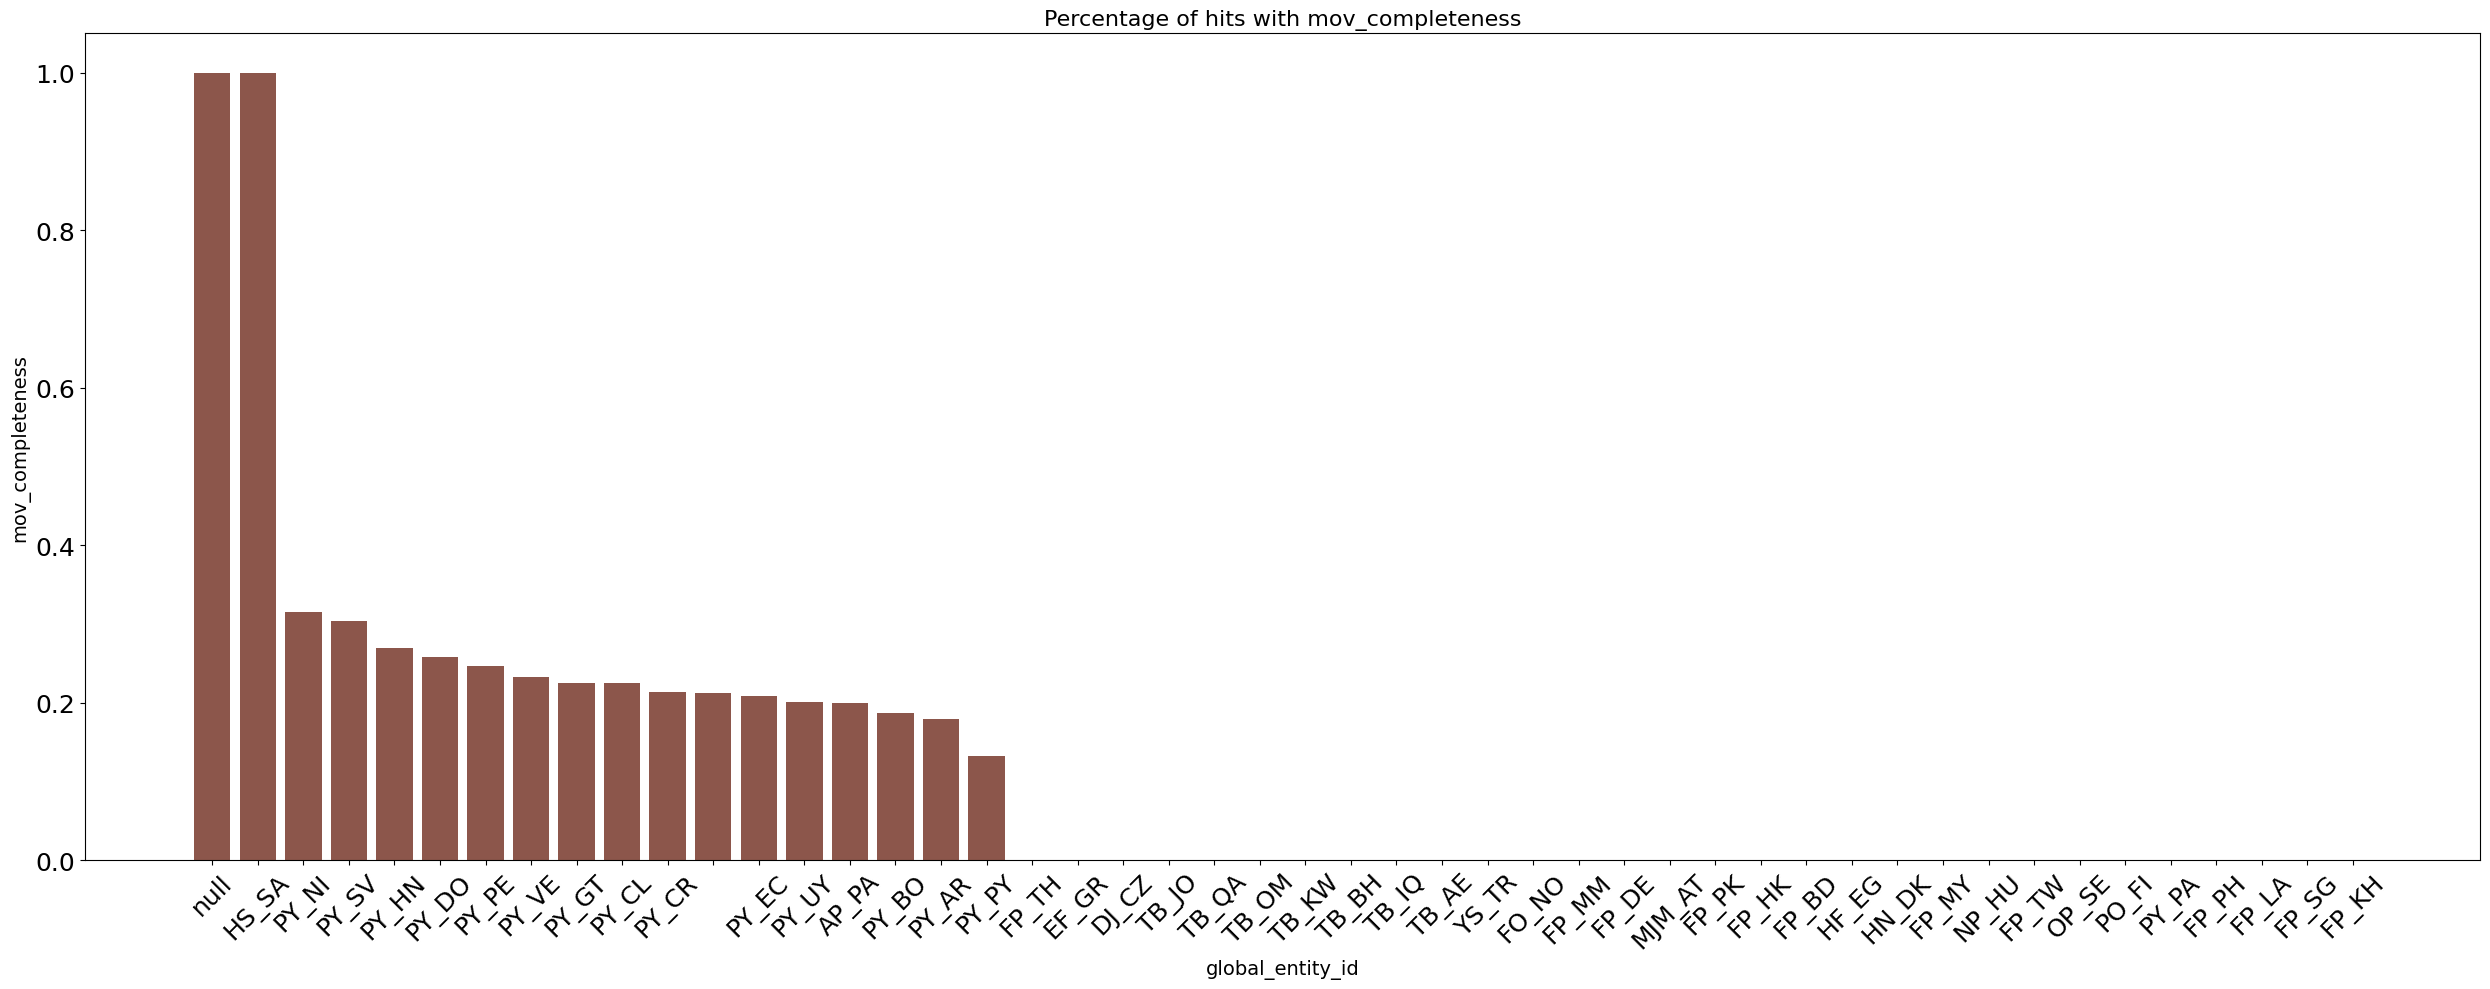

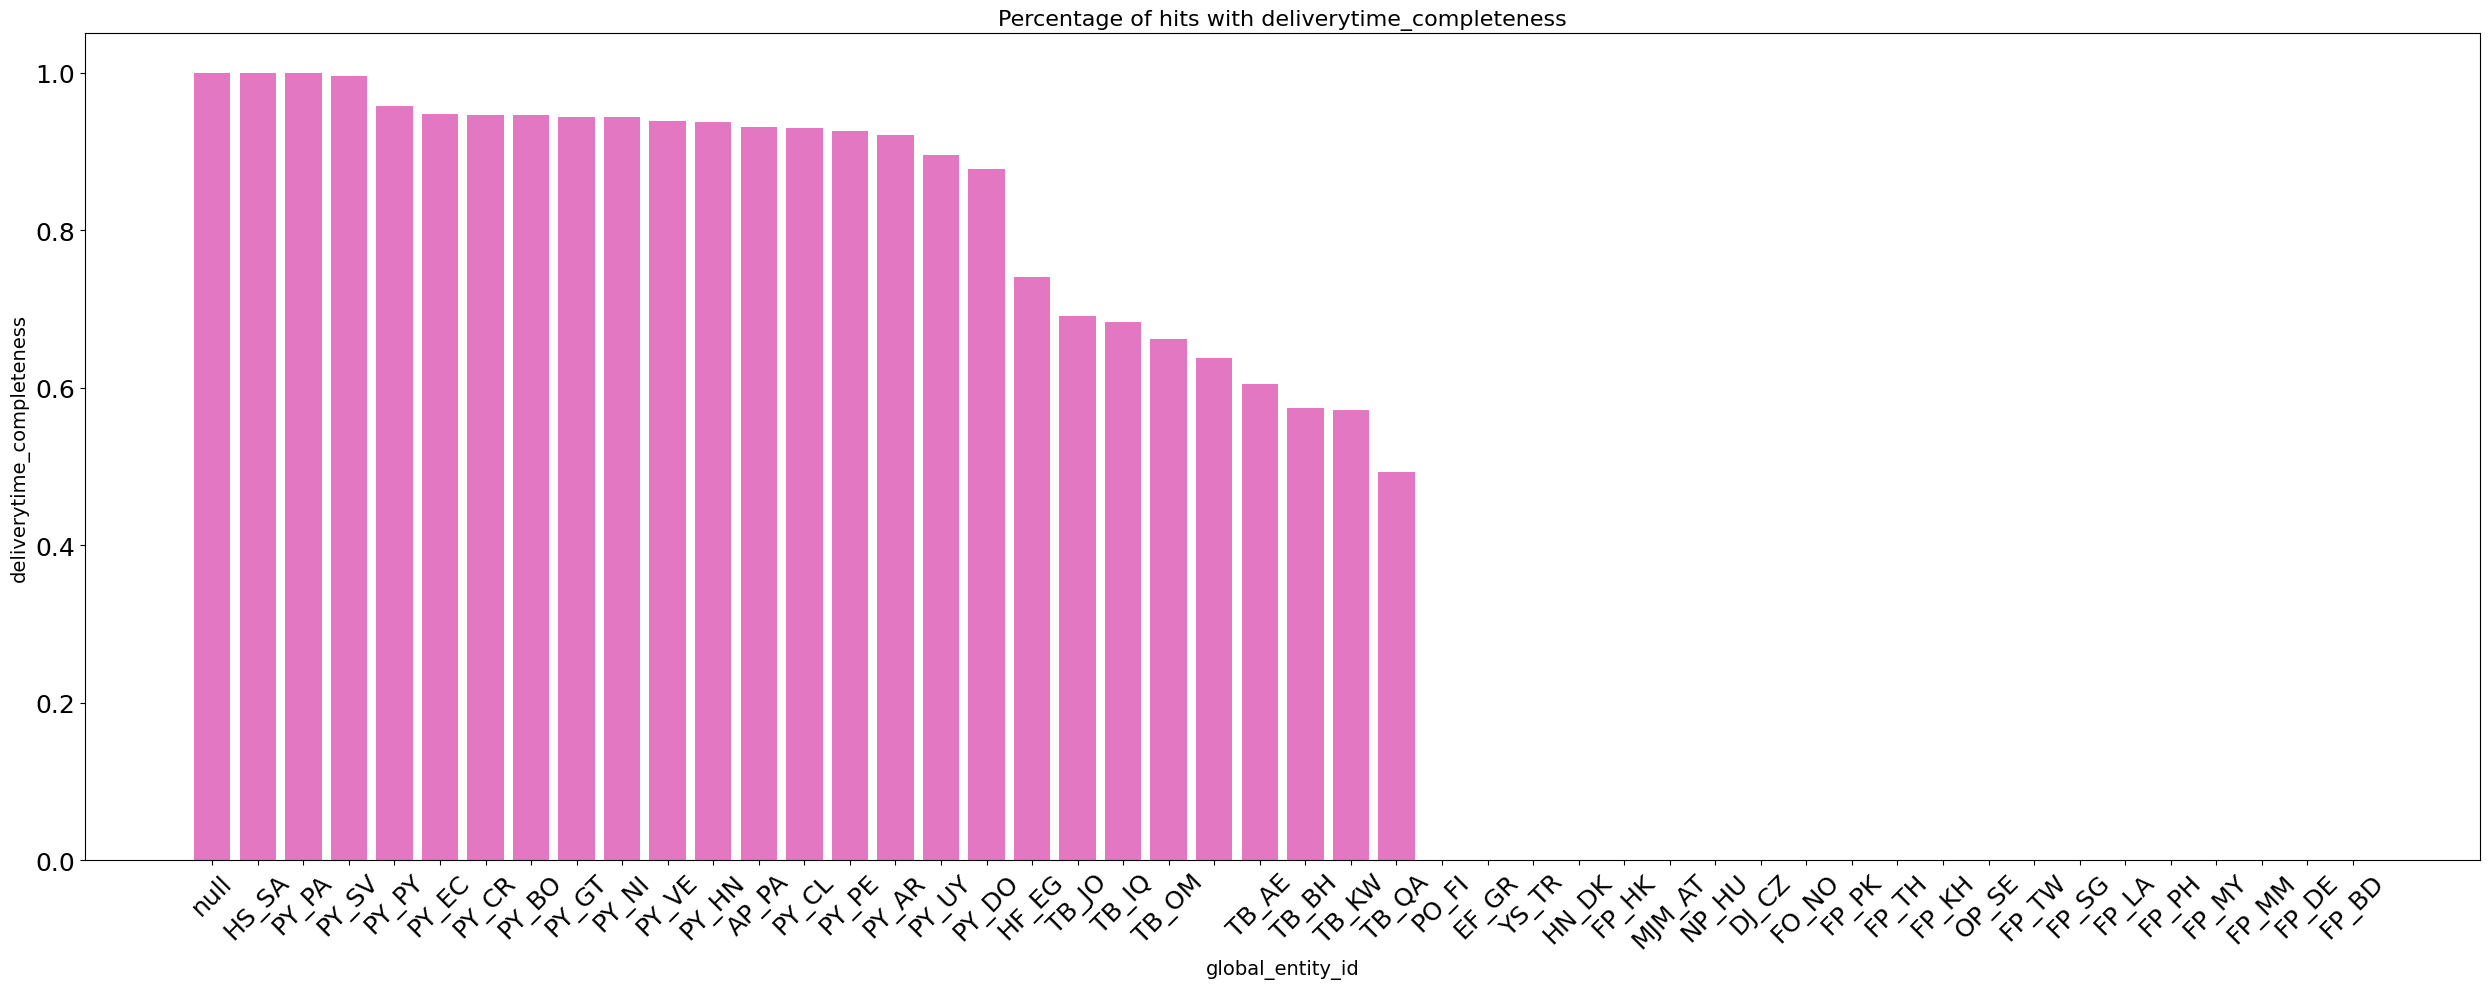

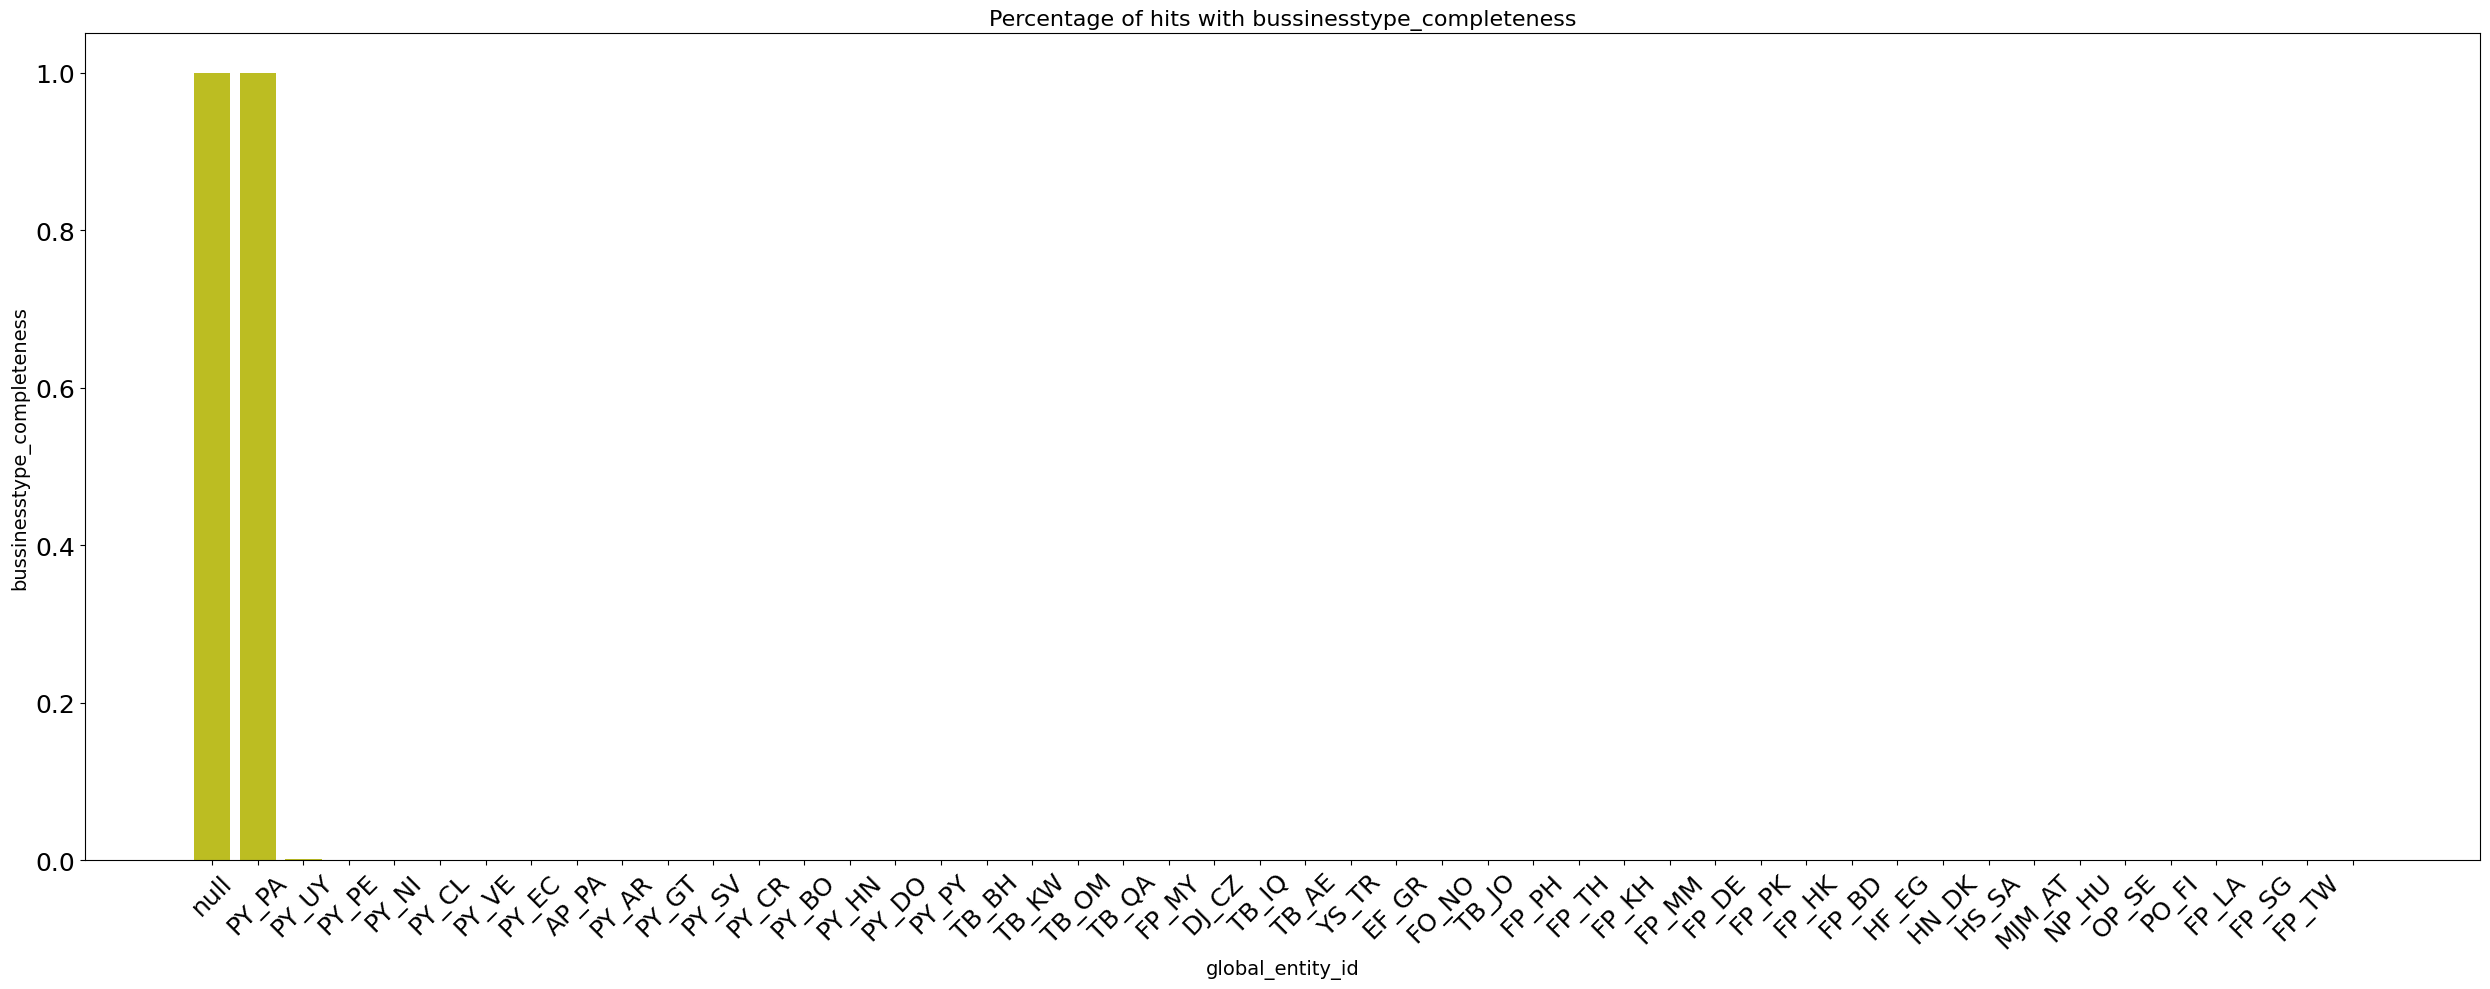

In [73]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)
start_date = '2024-06-01'
end_date = '2024-06-01'
# start_date_dps = '2024-05-31'
# end_date_dps = '2024-06-01'


#impression_data_completeness = client.query(impressions_completeness(start_date, end_date)).to_dataframe()


impression_data_completeness['entity_grouping'] = impression_data_completeness['global_entity_id'].str.split('_').str[0]
impression_data_completeness = impression_data_completeness.dropna(subset=['global_entity_id'])

cols = ['fee_completeness', 'quality_completeness', 'quantity_completeness', 
        'mov_completeness', 'deliverytime_completeness', 'bussinesstype_completeness']

impression_data_completeness = impression_data_completeness.sort_values(by = 'entity_grouping')

x_axis_column = 'global_entity_id'

# Extract x-axis data
x_data = impression_data_completeness[x_axis_column]

# Generate a colormap
num_cols = len(cols)
color_map = plt.cm.get_cmap('tab10')  

# Iterate through each column in cols and plot
for i, col in enumerate(cols):
    # Sort data by the current column
    sorted_data = impression_data_completeness.sort_values(by=col, ascending = False)
    
    # Extract x-axis data
    x_data = sorted_data[x_axis_column]

    # Create a figure and axis for plotting
    fig, ax = plt.subplots()
    fig.set_size_inches(25, 10, forward=True)

    # Plot the data with dynamically assigned color
    color = color_map(i / num_cols)  
    ax.bar(x_data, sorted_data[col], color=color)
    
    ax.set_xlabel(x_axis_column, fontsize=14)
    ax.set_ylabel(col, fontsize=14)
    ax.set_title(f'Percentage of hits with {col}', fontsize=16)
    
    plt.xticks(rotation=45, fontsize=18)
    plt.yticks(fontsize=18)
    
    for bar in col:
        yval = bar.get_height()
        ax.annotate(f'{yval:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, yval), 
                    xytext=(0, 5),
                    textcoords='offset points',
                    ha='center', va='bottom', fontsize=14)

    # Show plot
    plt.tight_layout()
    plt.show()

In [10]:
abc = f"""
SELECT 
    session_key,
    eventAction,
    eventTimestamp,
    eventVariables_json,
    global_entity_id,
    JSON_VALUE(eventVariables_json, "$.globalEntityId")
  FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
    WHERE partition_date = '2024-06-18'
    AND session_key = 'SlXTIyTYecRbys2s4lOZUA=='

"""





c = client.query(abc).to_dataframe()
c

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/cloud/bigquery/_pandas_helpers.py:207: UserWarning: Unable to determine type for field 'eventVariables_json'.
  warnings.warn("Unable to determine type for field '{}'.".format(bq_field.name))


,session_key,eventAction,eventTimestamp,eventVariables_json,global_entity_id,f0_
0,SlXTIyTYecRbys2s4lOZUA==,holdout_group.participated,2024-06-18 18:24:39.305000+00:00,"{'SubmittedVoucher': None, 'adjustAdgroup': 'u...",TB_AE,None
1,SlXTIyTYecRbys2s4lOZUA==,swimlane.loaded,2024-06-18 18:21:44.153000+00:00,"{'SubmittedVoucher': None, 'adjustAdgroup': 'u...",TB_AE,None
2,SlXTIyTYecRbys2s4lOZUA==,app.opened,2024-06-18 18:21:28.014000+00:00,"{'SubmittedVoucher': None, 'adjustAdgroup': 'u...",TB_AE,None
3,SlXTIyTYecRbys2s4lOZUA==,holdout_group.participated,2024-06-18 18:35:44.094000+00:00,"{'SubmittedVoucher': None, 'adjustAdgroup': 'u...",TB_AE,None
4,SlXTIyTYecRbys2s4lOZUA==,holdout_group.participated,2024-06-18 18:24:39.311000+00:00,"{'SubmittedVoucher': None, 'adjustAdgroup': 'u...",TB_AE,None
...,...,...,...,...,...,...
565,SlXTIyTYecRbys2s4lOZUA==,shop_impressions.loaded,2024-06-18 18:22:07.684000+00:00,"{'SubmittedVoucher': None, 'adjustAdgroup': 'u...",TB_AE,None
566,SlXTIyTYecRbys2s4lOZUA==,shop_details.loaded,2024-06-18 18:34:52.626000+00:00,"{'SubmittedVoucher': None, 'adjustAdgroup': 'u...",TB_AE,None
567,SlXTIyTYecRbys2s4lOZUA==,ab_test.participated,2024-06-18 18:21:57.642000+00:00,"{'SubmittedVoucher': None, 'adjustAdgroup': 'u...",TB_AE,None
568,SlXTIyTYecRbys2s4lOZUA==,holdout_group.participated,2024-06-18 18:28:50.903000+00:00,"{'SubmittedVoucher': None, 'adjustAdgroup': 'u...",TB_AE,None


In [34]:
dict = {}

for key, value in c['eventVariables_json'][0].items():
    if value != None:
        print(key, value)
        dict[key] = value

adjustAdgroup unknown
adjustAdid f88f9088a694c4719eb0c0c403c694c8
adjustCampaign sem_rmo_web_dma_ma_[OM_NAT_AllCategories]_Test_PerformanceMax_tCPA_shp_AR (20993838213)
adjustCreative cross-network cross-network
adjustLabel N/A
adjustNetwork Google Ads Performance Max
adjustTrackerToken 19emtmno
advertisingId 01b8e481-c995-4d5d-860c-5d00535e1995
customerCode 18148518
dataLayerEventName holdout_group_participated
eventAction holdout_group.participated
featureFlagKey exp_ordering_egyptian_dialect
featureName holdout_group_participated
flutterTrackingLibVersion 1.0.0
hitMatchId 1718735078898.653595326707054389.oUYUEsonWl
holdoutEvaluation false
holdoutKey holdout_shopping_2024
holdoutVariation Control
isTrackingLibraryFlutter true
languageSelected en
locationAddress Al Khuwair Street, Sun and sands factory outlet , 2, B
locationArea 5651
locationCity 39
locationCountry OMN
locationLat 23.596251029171086
locationLon 58.433027788996704
perseusClientId 1685246682346.795985672555142599.kJihCN

In [37]:
pd.DataFrame(dict.items(), columns=['Key', 'Value'])

,Key,Value
0,adjustAdgroup,unknown
1,adjustAdid,f88f9088a694c4719eb0c0c403c694c8
2,adjustCampaign,sem_rmo_web_dma_ma_[OM_NAT_AllCategories]_Test...
3,adjustCreative,cross-network cross-network
4,adjustLabel,N/A
5,adjustNetwork,Google Ads Performance Max
6,adjustTrackerToken,19emtmno
7,advertisingId,01b8e481-c995-4d5d-860c-5d00535e1995
8,customerCode,18148518
9,dataLayerEventName,holdout_group_participated


In [8]:
query = f"""
      SELECT  eventAction
      FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events` 
            LEFT JOIN UNNEST(eventVariables) v1 ON v1.name = 'globalEntityId' 
      WHERE partition_date = "2024-06-18" 
            AND session_key is not null
            AND COALESCE(global_entity_id, v1.value) = 'PY_PE'
      group by 1
"""

test = client.query(query).to_dataframe()
test

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,eventAction
0,hero_banner.swiped
1,repeat_summary.clicked
2,login_signup_by_phone.clicked
3,wallet_transactions_summary.loaded
4,order_status.delivered.loaded
...,...
499,out_of_delivery_zone.shown
500,menu_section.closed
501,phone_validation.failed
502,highlight_banner.clicked


In [9]:
test.to_csv()

',eventAction\n0,hero_banner.swiped\n1,repeat_summary.clicked\n2,login_signup_by_phone.clicked\n3,wallet_transactions_summary.loaded\n4,order_status.delivered.loaded\n5,order_details.closed\n6,campaign_landing.clicked\n7,payment_challenge.loaded\n8,online_payment_add_card.proceeded\n9,personal_info_screen.clicked\n10,order_delivery_notes.closed\n11,my_orders_feedback.clicked\n12,view_hub.loaded\n13,compliance.initialize\n14,payment_method.loaded\n15,push.opened\n16,tip_clicked\n17,courier_onboarding.loaded\n18,challenges_requested.success\n19,bnpl.loaded\n20,courier_address.loaded\n21,my_orders_repeat.clicked\n22,widget.clicked\n23,header_location.loaded\n24,shop_list.expanded\n25,shop_list.loaded\n26,phone_validation_insert.code\n27,joker_banner.loaded\n28,cancel_my_order_reasons.loaded\n29,my_account_feedback.failed\n30,priority_delivery.clicked\n31,product.search.succeeded\n32,item_replacement.confirmed\n33,bnpl.proceeded\n34,substitution_preference.opened\n35,banner.shown\n36,place

In [2]:
def impression_data_q(start_d, end_d, start_d_dps, end_d_dps, e_id):

        query = f"""
        with impression_data as (
        SELECT 
                DISTINCT
                session_key
                ,COALESCE(global_entity_id, v1.value) AS global_entity_id
                ,COALESCE(platform, v2.value) AS platform
                ,COALESCE(shopId, v7.value) AS shopId
                ,COALESCE(v13.value, '') AS mov_impressions
                ,COALESCE(v14.value, '') AS df_impressions
                ,COALESCE(v15.value, '') AS dt_impressions
                ,eventAction
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events` 
        LEFT JOIN UNNEST(eventVariables) v1 ON v1.name = 'globalEntityId'
        LEFT JOIN UNNEST(eventVariables) v2 ON v2.name = 'eventPlatform'
        LEFT JOIN UNNEST(eventVariables) v7 ON v7.name = 'shopId'
        LEFT JOIN UNNEST(eventVariables) v13 ON v13.name = 'shopMinimumOrderValue'
        LEFT JOIN UNNEST(eventVariables) v14 ON v14.name IN ('shopDeliveryFee', 'vendorDeliveryFee')
        LEFT JOIN UNNEST(eventVariables) v15 ON v15.name = 'shopDeliveryTime'
        WHERE eventAction IN ('shop_impressions.loaded')
        AND partition_date BETWEEN \"""" + start_d + """\" and \"""" + end_d + """\"
        AND COALESCE(global_entity_id, v1.value) = """ + e_id + """
        --AND session_key = 'SlXTIyTYecRbys2s4lOZUA=='
        ), dps_data as (
        SELECT  perseus_session_key
                ,entity_id
                ,platform
                ,a.vendor_code
                ,a.vendor_delivery_fee df_dps
                ,a.minimum_order_value mov_dps
                ,a.vendor_delivery_time dt_dps
        FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_perseus_sessions` cross join unnest (events) as a
        WHERE created_date BETWEEN \"""" + start_d_dps + """\" and \"""" + end_d_dps + """\"
        AND perseus_session_key is not null
        AND a.event_action = 'shop_impressions.loaded'
        AND entity_id = """ + e_id + """
        --AND entity_id is not null
        --AND perseus_session_key = 'SlXTIyTYecRbys2s4lOZUA=='
        )
        select   id.global_entity_id entity_id
                ,id.platform platform
                ,id.session_key session_key
                ,count(distinct id.shopId ) as total_vendors
                ,count(id.df_impressions) non_null_df_impressions
                ,count(id.mov_impressions) non_null_mov_impressions
                ,count(id.dt_impressions) non_null_dt_impressions 
                ,count(dpsd.df_dps) non_null_df_dps
                ,count(dpsd.mov_dps) non_null_mov_dps
                ,count(dpsd.dt_dps) non_null_dt_dps 
                ,count(distinct case when id.df_impressions = dpsd.df_dps then shopId else NULL end) as count_df_match
                ,count(distinct case when id.mov_impressions = dpsd.mov_dps then shopId else NULL end) as count_mov_match
                ,count(distinct case when id.dt_impressions = dpsd.dt_dps then shopId else NULL end) as count_dt_match
        from impression_data id
        left join dps_data dpsd on dpsd.perseus_session_key = id.session_key and dpsd.vendor_code = id.shopId
        group by 1,2,3
        """

        return query


#test = client.query(query).to_dataframe()

In [4]:
50 * 2

100

In [3]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)
start_date = '2024-06-01'
end_date = '2024-06-01'
start_date_dps = '2024-05-31'
end_date_dps = '2024-06-01'


# entity_id = ('PY_AR','PY_BO','PY_CL','PY_CR','PY_DO','PY_EC','PY_GT','PY_HN','PY_NI','AP_PA','PY_PE',
#              'PY_PY','PY_SV','PY_UY','PY_VE','FP_BD','FP_KH','FP_HK','FP_LA','FP_MY','FP_MM','FP_PK','FP_PH',
#              'FP_SG','FP_TW','FP_TH','MJM_AT','FY_CY','DJ_CZ','HN_DK','PO_FI','EF_GR','NP_HU','FO_NO','OP_SE',
#              'FP_SK','TB_AE','HS_BH','HS_BH','TB_BH','HF_EG','TB_IQ','TB_JO','TB_KW','TB_OM','TB_QA','HS_SA','YS_TR','YS_TR')

#entity_id = ('PY_AR','PY_BO','PY_CL','PY_CR','PY_DO','PY_EC','PY_GT','PY_HN','PY_NI','AP_PA','PY_PE')

entity_id = "'PY_PE'"


impression_d = client.query(impression_data_q(start_date, end_date, start_date_dps, end_date_dps, entity_id)).to_dataframe()

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [108]:
for entity in entity_id:
    print(entity)

PY_AR
PY_BO
PY_CL
PY_CR
PY_DO
PY_EC
PY_GT
PY_HN
PY_NI
AP_PA
PY_PE
PY_PY
PY_SV
PY_UY
PY_VE
FP_BD
FP_KH
FP_HK
FP_LA
FP_MY
FP_MM
FP_PK
FP_PH
FP_SG
FP_TW
FP_TH
MJM_AT
FY_CY
DJ_CZ
HN_DK
PO_FI
EF_GR
NP_HU
FO_NO
OP_SE
FP_SK
TB_AE
HS_BH
HS_BH
TB_BH
HF_EG
TB_IQ
TB_JO
TB_KW
TB_OM
TB_QA
HS_SA
YS_TR
YS_TR


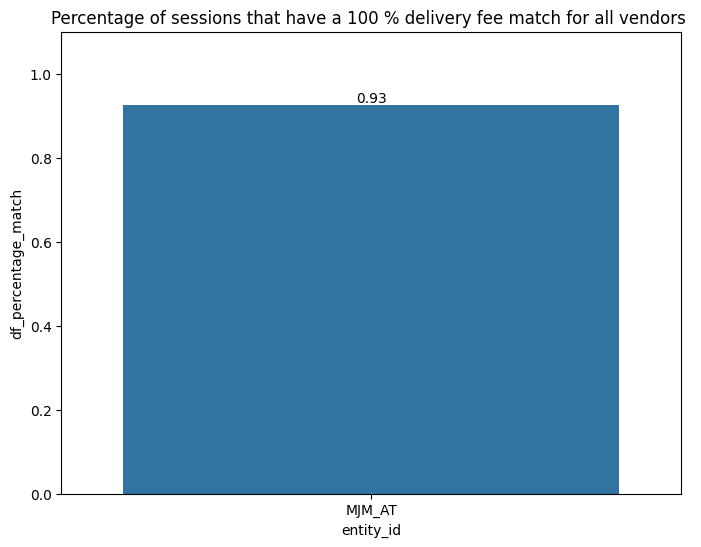

In [107]:
# Creating the conditional columns
test['sessions_df_match'] = test.apply(lambda row: 1 if row['total_vendors'] == row['count_df_match'] else 0, axis=1)
test['sessions_mov_match'] = test.apply(lambda row: 1 if row['total_vendors'] == row['count_mov_match'] else 0, axis=1)
test['sessions_dt_match'] = test.apply(lambda row: 1 if row['total_vendors'] == row['count_dt_match'] else 0, axis=1)

a = test.groupby('entity_id').agg({'sessions_df_match': 'sum', 'session_key': 'count'}).reset_index()

# Calculating the percentage mismatch
a['df_percentage_match'] = a['sessions_df_match'] / a['session_key']

# Plotting with seaborn
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='entity_id', y='df_percentage_match', data=a)

# Adding percentage labels on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

plt.ylim(0, 1.1)  # Extend y-axis limit to make sure labels fit within the plot
plt.ylabel('df_percentage_match')
plt.title('Percentage of sessions that have a 100 % delivery fee match for all vendors ')
plt.show()

In [80]:
test[test['count_mov_match'] > 0]

,entity_id,platform,session_key,total_vendors,non_null_df_impressions,non_null_mov_impressions,non_null_dt_impressions,non_null_df_dps,non_null_mov_dps,non_null_dt_dps,count_df_match,count_mov_match,count_dt_match


In [36]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)
start_date = '2024-06-01'
end_date = '2024-06-01'

tt = f"""
  SELECT 
    partition_date,
    IFNULL(global_entity_id, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('globalEntityId'))) global_entity_id,
    session_key,
    eventVariables
  FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
  WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
    AND eventAction IN ('shop_impressions.loaded')
    AND session_key = '2hfGxiUpOdChbyOhA1YRIQ=='
"""

test = client.query(tt).to_dataframe()


/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [39]:
print(test['eventVariables'][0])

[{'name': 'locationCountryHostname', 'value': 'Ecuador'}
 {'name': 'hitMatchId', 'value': '1717274770972.000000001375247997.0001uxcy3m'}
 {'name': 'eventPlatform', 'value': 'b2c'}
 {'name': 'hostname', 'value': 'www.pedidosya.com.ec'}
 {'name': 'gtmContainerVersion', 'value': '263'}
 {'name': 'shopRatingQuality', 'value': '4.59'}
 {'name': 'transactionId', 'value': '1189995736'}
 {'name': 'locationCountry', 'value': 'EC'}
 {'name': 'gtmContainerID', 'value': 'GTM-NZMRRPN'}
 {'name': 'setupSource', 'value': 'gtm'}
 {'name': 'shopSponsoring', 'value': 'False'}
 {'name': 'deliveryProvider', 'value': 'OWN_DELIVERY'}
 {'name': 'businessType', 'value': 'RESTAURANT,PHARMACY'}
 {'name': 'shopDeliveryTime', 'value': '15-30 min'}
 {'name': 'orderId', 'value': '1189995736'}
 {'name': 'shopDeliveryFee', 'value': '0.0'}
 {'name': 'platformVersion', 'value': 'microsite'}
 {'name': 'shopListBusinessType', 'value': 'RESTAURANT'}
 {'name': 'shopMinimumOrderValue', 'value': '0.0'}
 {'name': 'platformTyp

In [48]:
lst = []
for item in test['eventVariables'][0]:
    lst.append(item['name'])

In [57]:
matching = [s for s in lst if "Vendor" in s]
matching


['fbContentViewVendor']

In [5]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)
start_date = '2024-06-01'
end_date = '2024-06-01'

tt = f"""
  SELECT 
    partition_date,
    IFNULL(global_entity_id, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('globalEntityId'))) global_entity_id,
    session_key,
    sessionId,
    IFNULL(platform, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('eventPlatform'))) platform,
    IFNULL(sessionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('perseusSessionId'))) perseus_session_id,
    IFNULL(hitMatchId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('perseusHitMatchId'))) perseus_hit_match_id,
    IFNULL(transactionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('transactionId','orderId'))) orderId,
    IFNULL(shopListType, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopListType'))) shopListType,
    IFNULL(shopId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopId'))) shopId,
    IFNULL(shopPosition, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopPosition'))) shopPosition,
    IFNULL(eventOrigin, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('origin'))) eventOrigin,
    IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopRatingQuality')), '') shopRatingQuality,
    IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('businessType')), '') businessType,
    IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopRatingQuantity')), '') shopRatingQuantity,
    IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopMinimumOrderValue')), '') shopMinimumOrderValue,
    IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopDeliveryFee', 'vendorDeliveryFee')), '') vendor_delivery_fee,
    IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopDeliveryTime')), '') shopDeliveryTime
  FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
  WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
    AND eventAction IN ('shop_impressions.loaded')
    AND session_key = '2hfGxiUpOdChbyOhA1YRIQ=='
"""

test = client.query(tt).to_dataframe()


/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [255]:
tt_t = f"""
select o.country_code, 
  o.zone_name,
  o.platform_order_code, 
  o.dps_session_id,
  o.order_id
from fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders o
left join fulfillment-dwh-production.cl.countries c ON o.country_code = c.country_code
where o.dps_session_id = '1717030504197.000000001074390042.000052zlcp'
      and o.entity_id = 'PY_EC'
"""

test_tt = client.query(tt_t).to_dataframe()


/Users/shazeb.asad/Library/Python/3.9/lib/python/site-packages/google/cloud/bigquery/table.py:1727: UserWarning:

BigQuery Storage module not found, fetch data with the REST endpoint instead.



In [256]:
test_tt

,country_code,zone_name,platform_order_code,dps_session_id,order_id
0,ec,Loja,1190022159,1717030504197.000000001074390042.000052zlcp,24989621
1,ec,Loja,1188684465,1717030504197.000000001074390042.000052zlcp,24934209


In [247]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)
start_date = '2024-06-01'
end_date = '2024-06-01'

orders = f"""
    SELECT
        country_name,
        country_code,
        entity_id,
        created_date,
        order_id
    FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o
    where order_id = 1189995736
    """

orders_data_match = client.query(orders).to_dataframe()
orders_data_match

/Users/shazeb.asad/Library/Python/3.9/lib/python/site-packages/google/auth/_default.py:76: UserWarning:

Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 

/Users/shazeb.asad/Library/Python/3.9/lib/python/site-packages/google/cloud/bigquery/table.py:1727: UserWarning:

BigQuery Storage module not found, fetch data with the REST endpoint instead.



,country_name,country_code,entity_id,created_date,order_id


In [43]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)
start_date = '2024-06-01'
end_date = '2024-06-01'

query = f"""
with impression_data as (
  SELECT 
    session_key
    ,eventAction
    ,eventTimestamp
    ,COALESCE(global_entity_id,json_value(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
    ,platform AS platform
    ,sessionId AS perseus_session_id
    ,hitMatchId AS perseus_hit_match_id
    ,COALESCE(shopListType,json_value(eventVariables_json, "$.shopListType") ) AS shopListType
    ,COALESCE(shopId,json_value(eventVariables_json, "$.shopId") ) AS shopId
    ,COALESCE(shopPosition,json_value(eventVariables_json, "$.shopPosition") ) AS shopPosition
    ,COALESCE(eventOrigin,json_value(eventVariables_json, "$.origin") ) AS eventOrigin
    ,json_value(eventVariables_json, "$.shopRatingQuality")  AS shopRatingQuality
    ,json_value(eventVariables_json, "$.businessType")  AS businessType
    ,json_value(eventVariables_json, "$.shopRatingQuantity") AS shopRatingQuantity
    ,json_value(eventVariables_json, "$.shopMinimumOrderValue")  AS shopMinimumOrderValue
    ,coalesce(json_value(eventVariables_json, "$.vendorDeliveryFee"), json_value(eventVariables_json, "$.shopDeliveryFee")) AS vendor_delivery_fee
    ,json_value(eventVariables_json, "$.shopDeliveryTime")  AS shopDeliveryTime
  FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
  WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
    AND eventAction = 'shop_impressions.loaded'
),
aggregation as (
SELECT 
  global_entity_id
  ,count(distinct perseus_session_id) as total_sessions
  ,count(distinct perseus_hit_match_id) as total_hits
  ,count(*) as total_rows
  ,count(distinct case when cast(regexp_extract(vendor_delivery_fee,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as fee_hits
  ,count(distinct case when shopRatingQuality is not null then perseus_hit_match_id end) as quality_hits
  ,count(distinct case when shopRatingQuantity is not null then perseus_hit_match_id end) as quantity_hits
  ,count(distinct case when cast(regexp_extract(shopMinimumOrderValue,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as mov_hits
  ,count(distinct case when shopDeliveryTime is not null then perseus_hit_match_id end) as delivery_time_hits
  ,count(distinct case when businessType is not null then perseus_hit_match_id end) as business_type_hits
FROM impression_data
GROUP BY 1
)
select a.*,
       1.00 * (fee_hits / total_hits) fee_completeness
       ,1.00 * (quality_hits / total_hits) quality_completeness
       ,1.00 * (quantity_hits / total_hits ) quantity_completeness
       ,1.00 * (mov_hits / total_hits ) mov_completeness
       ,1.00 * (delivery_time_hits / total_hits ) deliverytime_completeness
       ,1.00 * (business_type_hits / total_hits ) bussinesstype_completeness
from aggregation a
"""

impression_data_completeness = client.query(query).to_dataframe()

<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\d'
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_2321/2952843350.py:28: SyntaxWarning: invalid escape sequence '\d'
  WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [63]:
impression_data_completeness)

,global_entity_id,total_sessions,total_hits,total_rows,fee_hits,quality_hits,quantity_hits,mov_hits,delivery_time_hits,business_type_hits,fee_completeness,quality_completeness,quantity_completeness,mov_completeness,deliverytime_completeness,bussinesstype_completeness,entity_grouping
32,,3,47,56,30,47,47,10,30,0,0.638298,1.000000,1.000000,0.212766,0.638298,0.000000,
17,AP_PA,75415,3519602,3534256,3180104,3512705,3512705,702636,3278625,2515,0.903541,0.998040,0.998040,0.199635,0.931533,0.000715,AP
13,DJ_CZ,54012,1506493,1508866,1503309,0,0,0,0,0,0.997886,0.000000,0.000000,0.000000,0.000000,0.000000,DJ
19,EF_GR,46372,1398480,1404024,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,EF
22,FO_NO,39191,1002663,1003752,984706,0,0,0,0,0,0.982091,0.000000,0.000000,0.000000,0.000000,0.000000,FO
48,FP_MY,622376,27767775,27862260,27737144,0,0,0,0,0,0.998897,0.000000,0.000000,0.000000,0.000000,0.000000,FP
18,FP_TW,1146228,65628155,65991460,65498165,0,0,0,0,0,0.998019,0.000000,0.000000,0.000000,0.000000,0.000000,FP
9,FP_TH,189028,6488885,6503088,6396220,0,0,0,0,0,0.985719,0.000000,0.000000,0.000000,0.000000,0.000000,FP
42,FP_SG,160190,7629375,7654032,7618117,0,0,0,0,0,0.998524,0.000000,0.000000,0.000000,0.000000,0.000000,FP
29,FP_PK,476231,17902454,18114745,17828455,0,0,0,0,0,0.995867,0.000000,0.000000,0.000000,0.000000,0.000000,FP


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_2321/1116800189.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10')


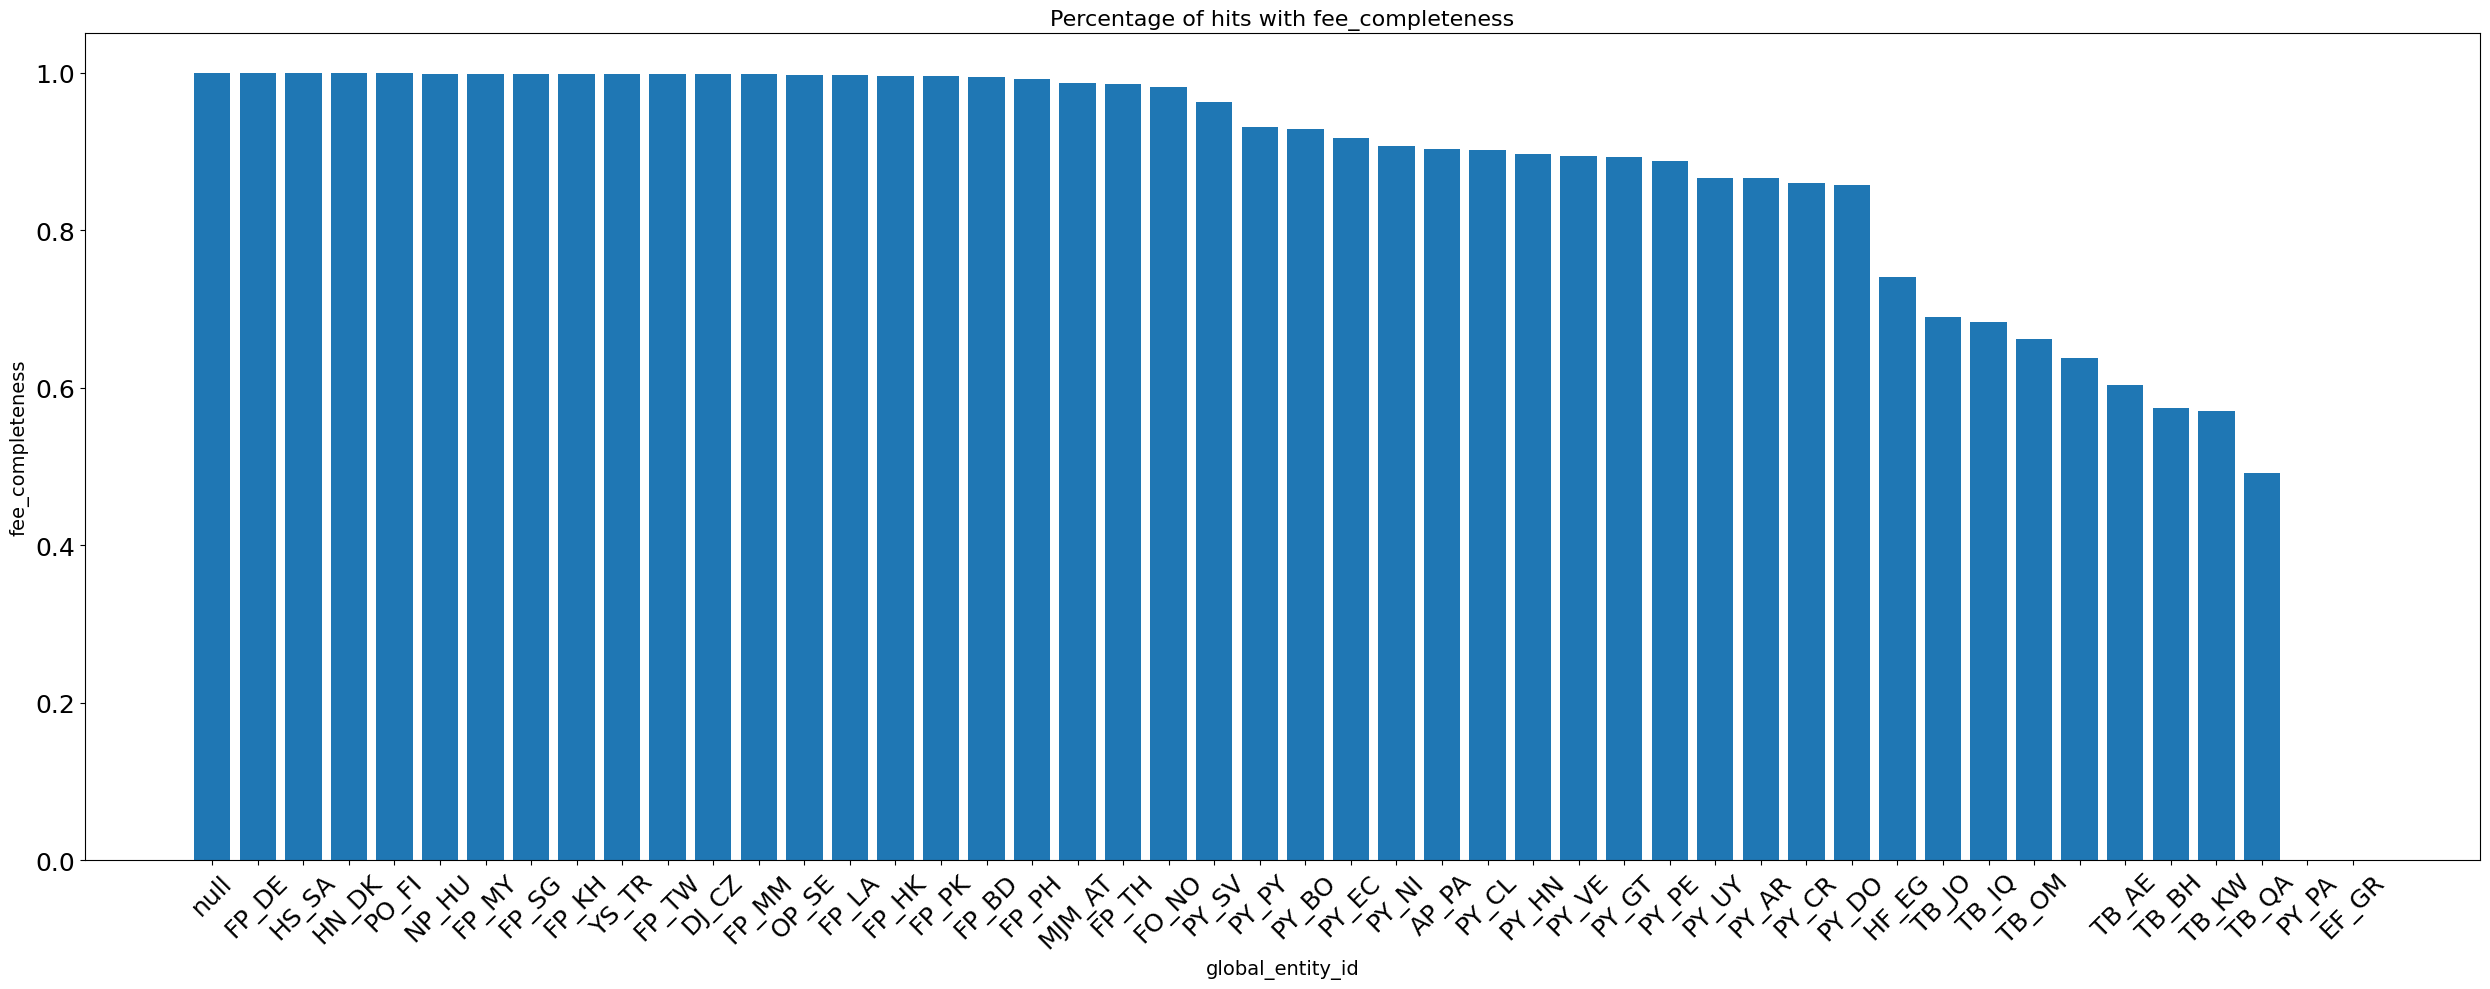

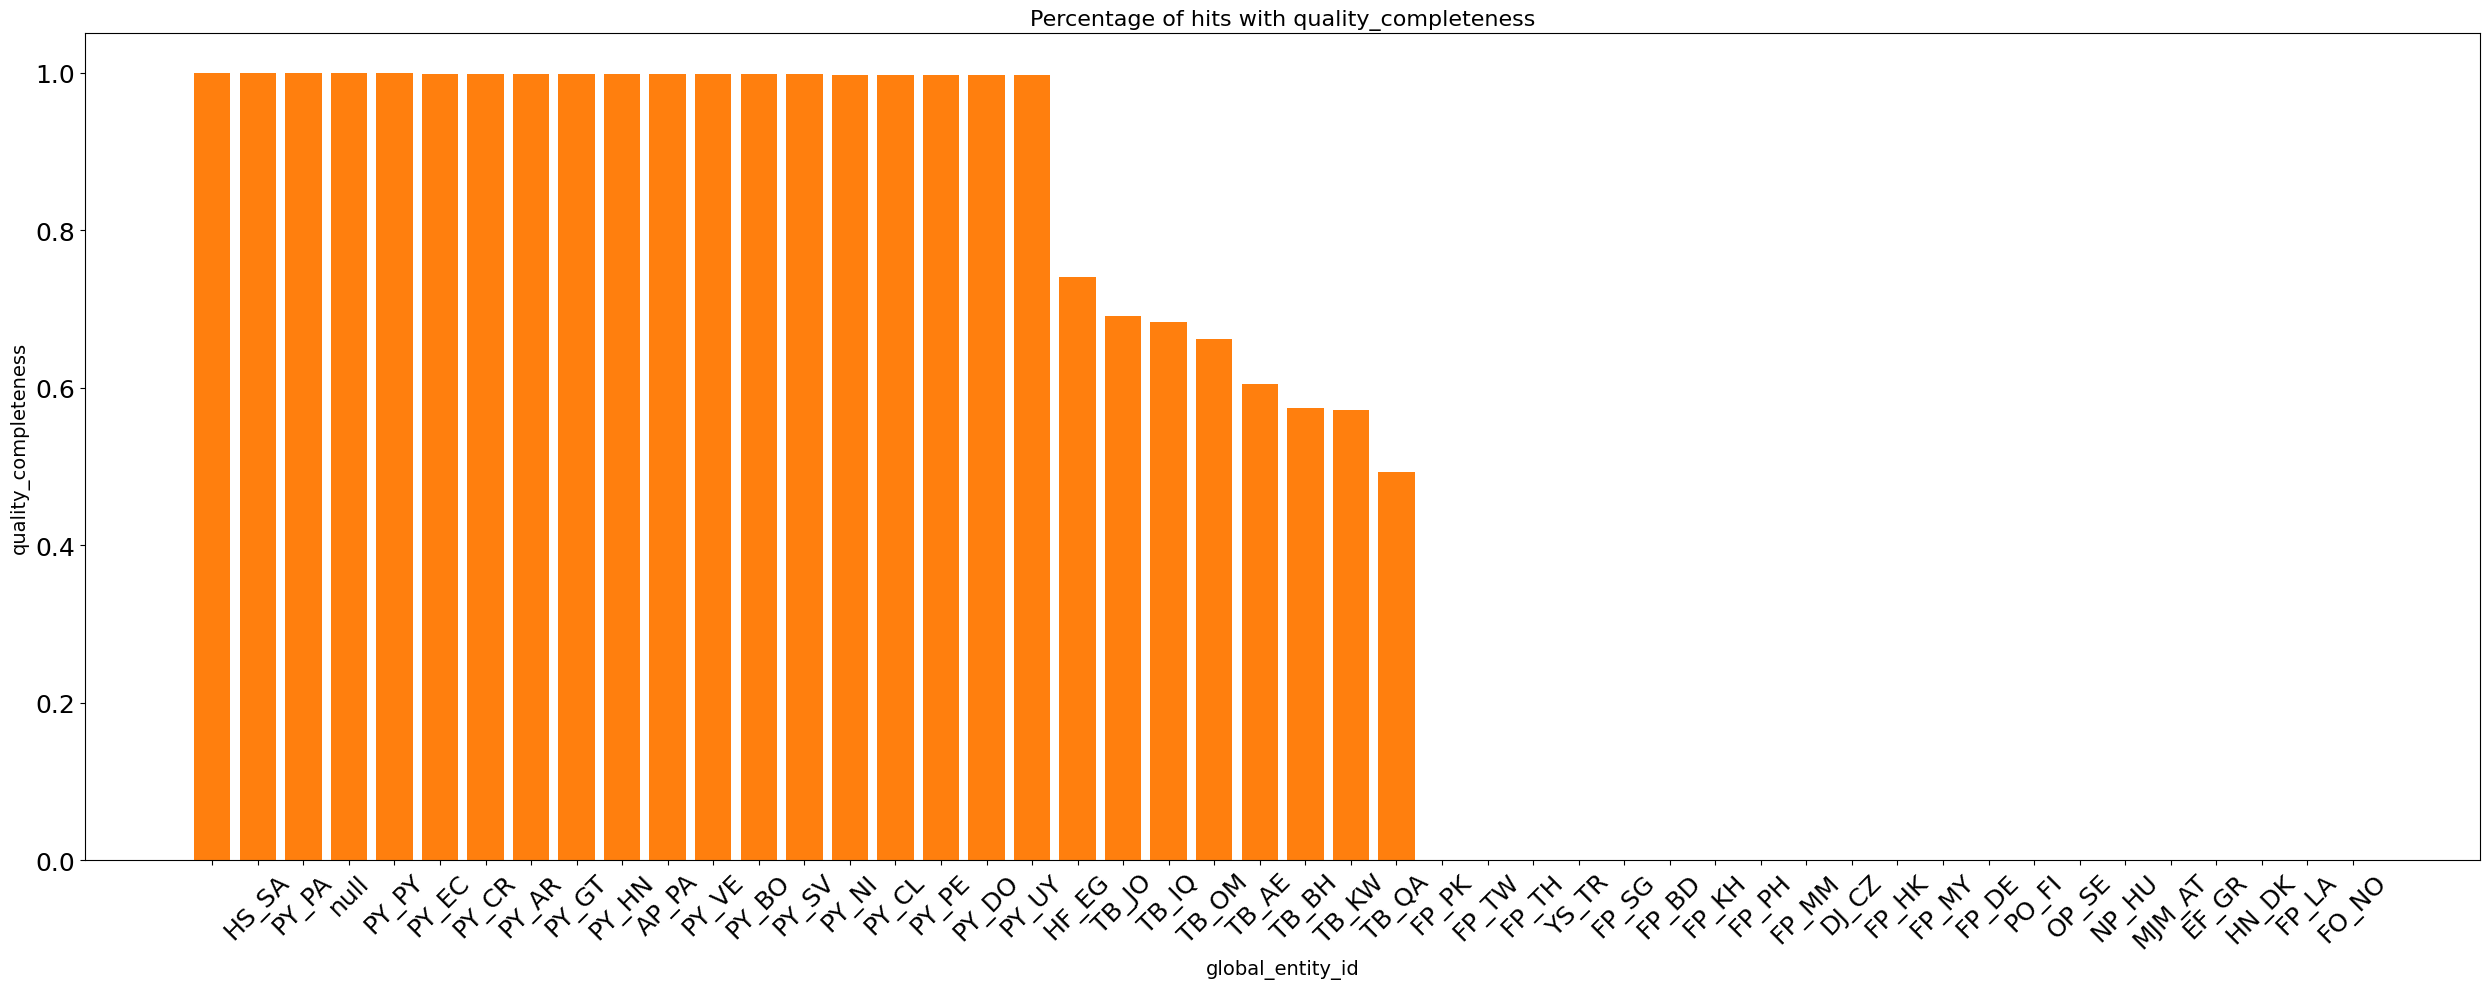

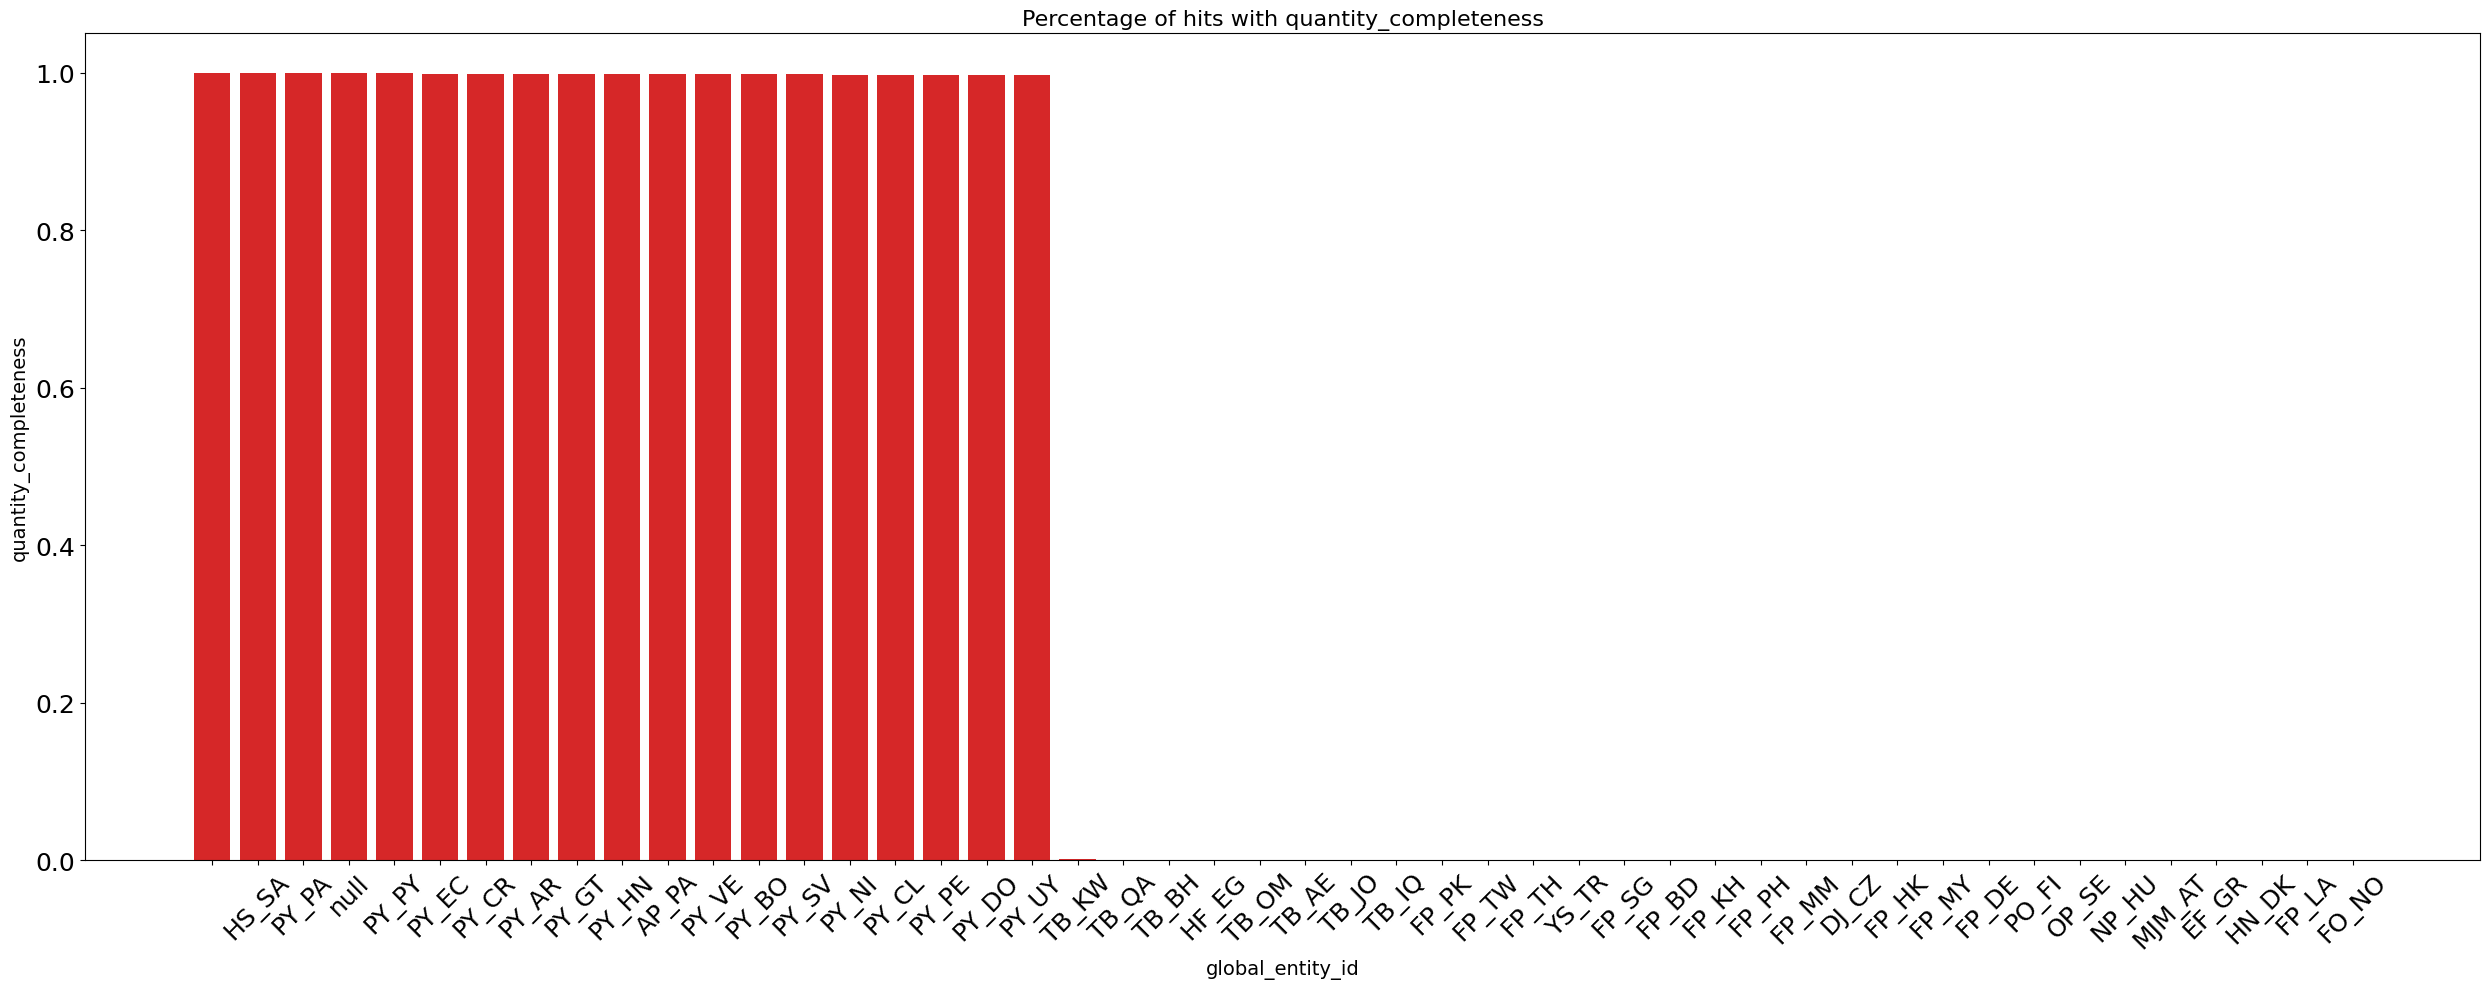

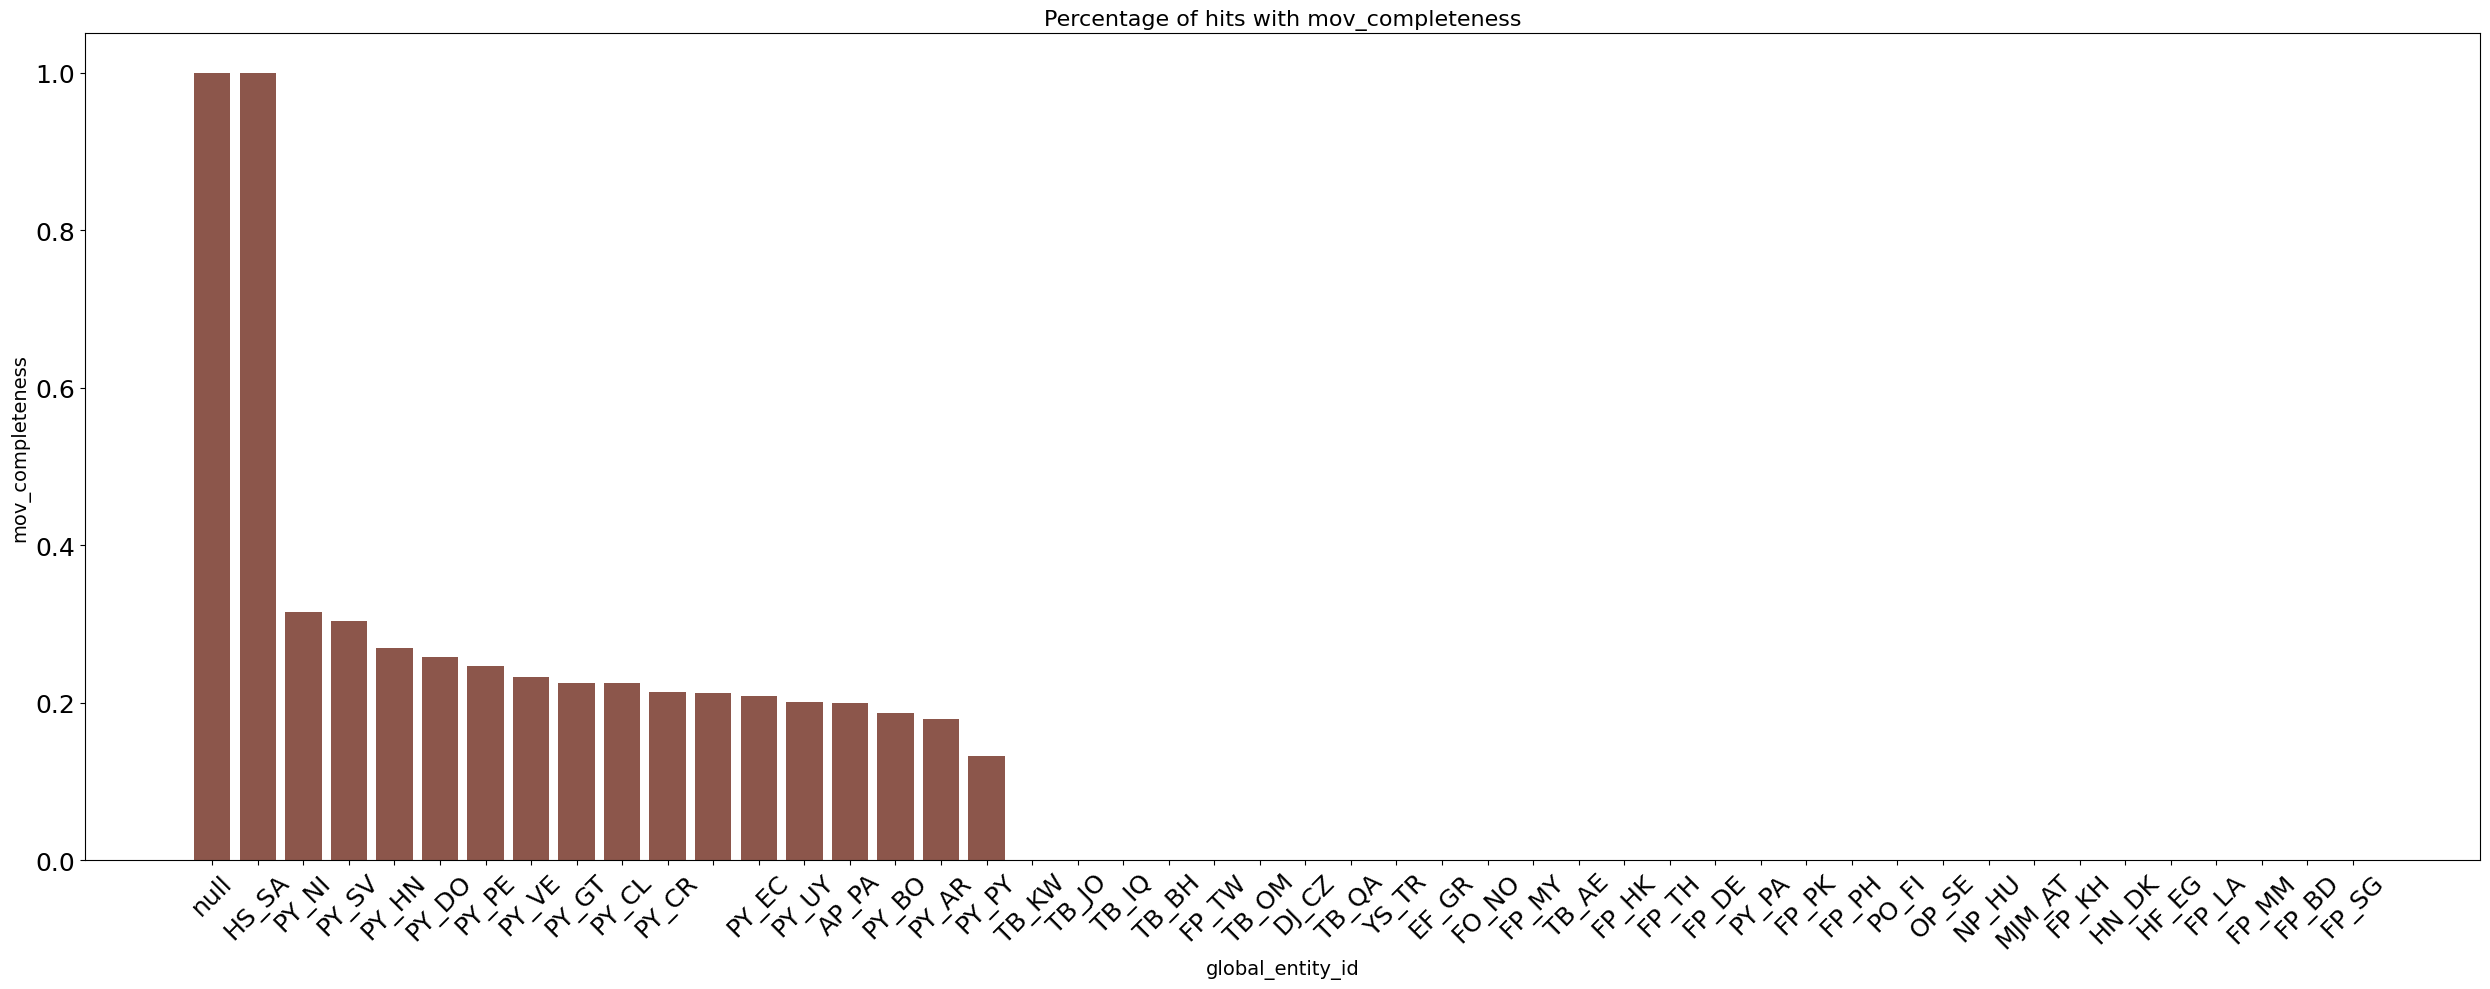

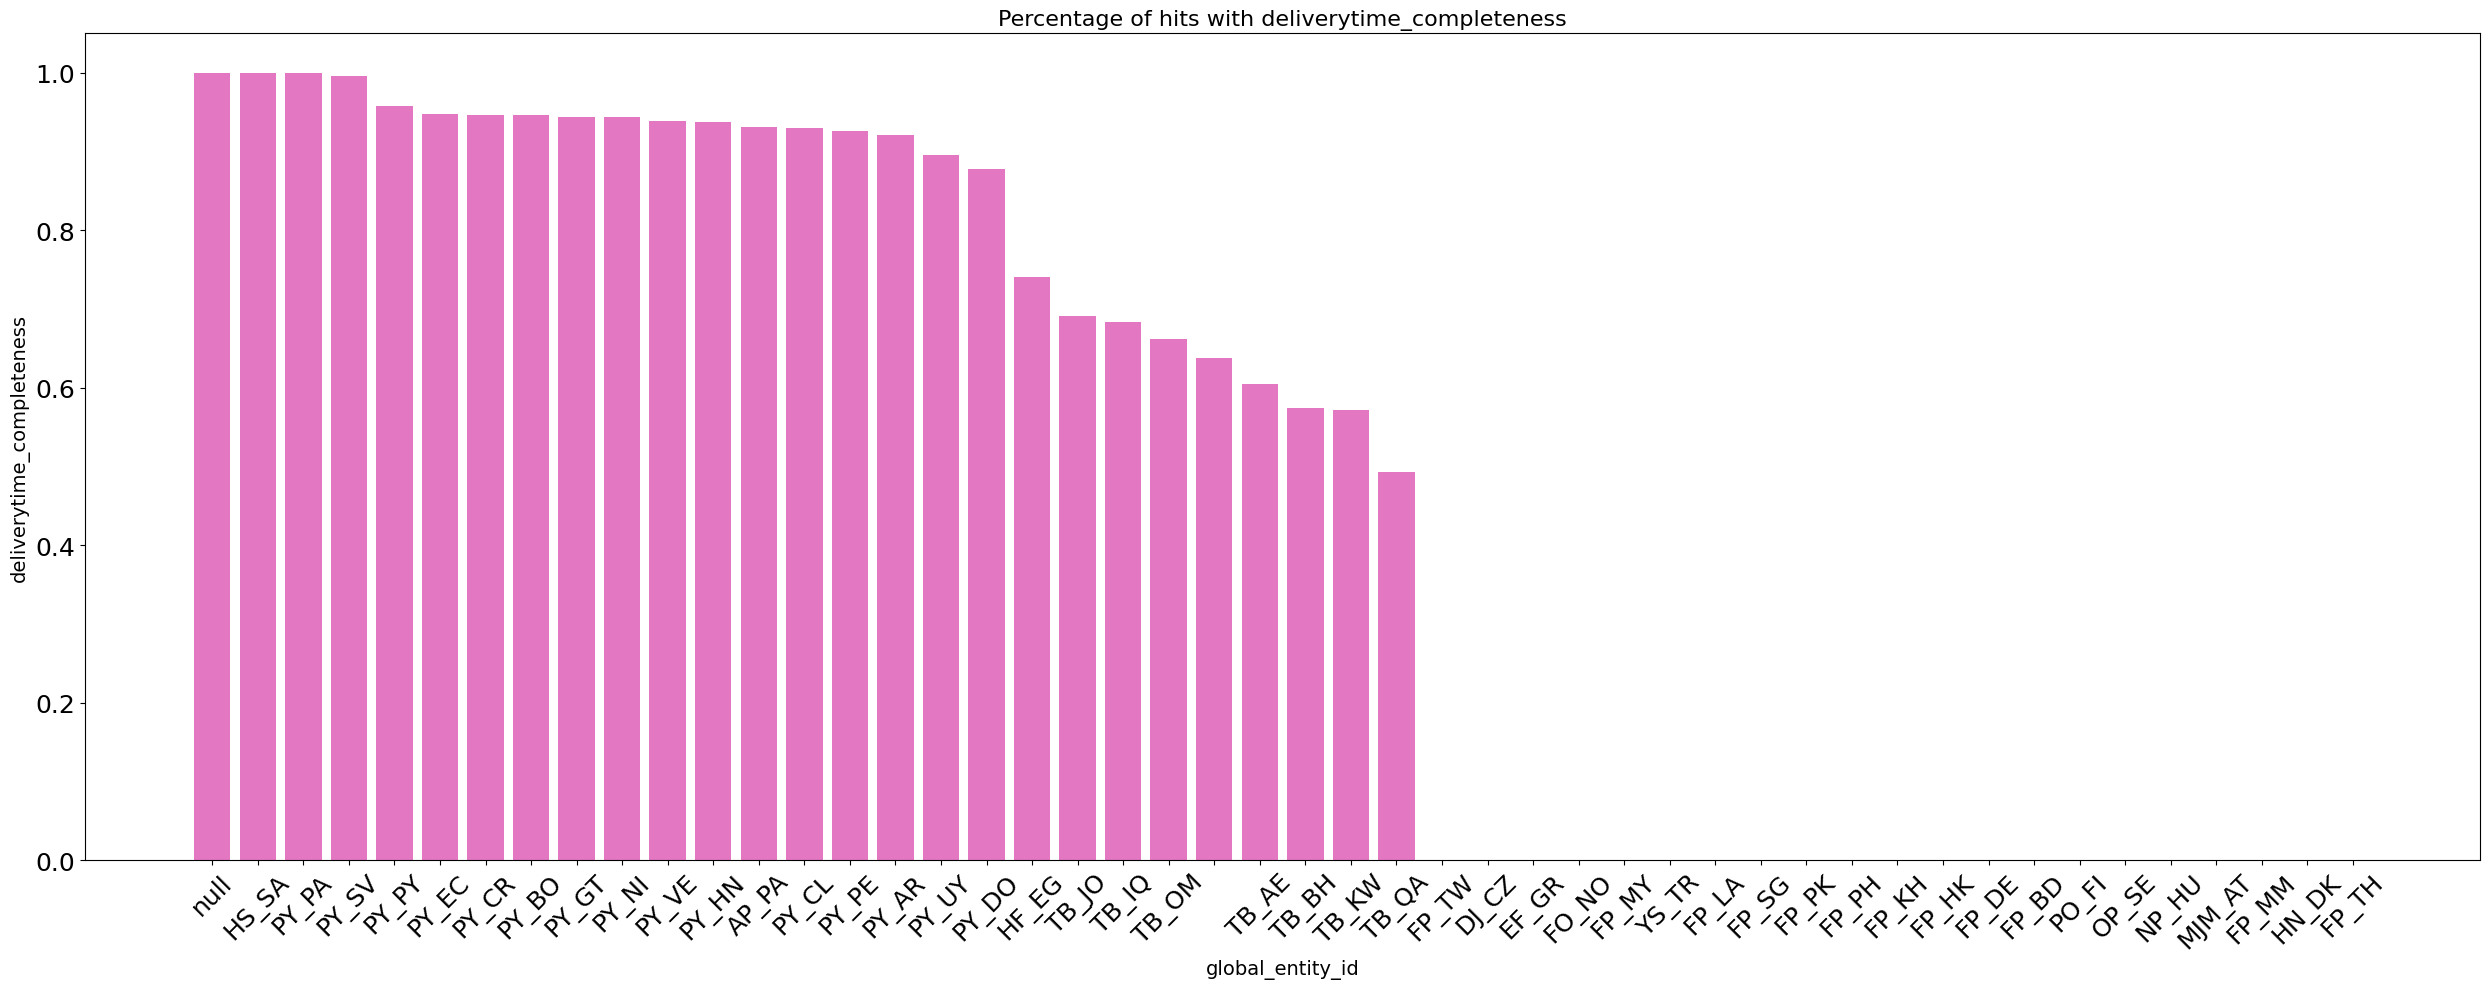

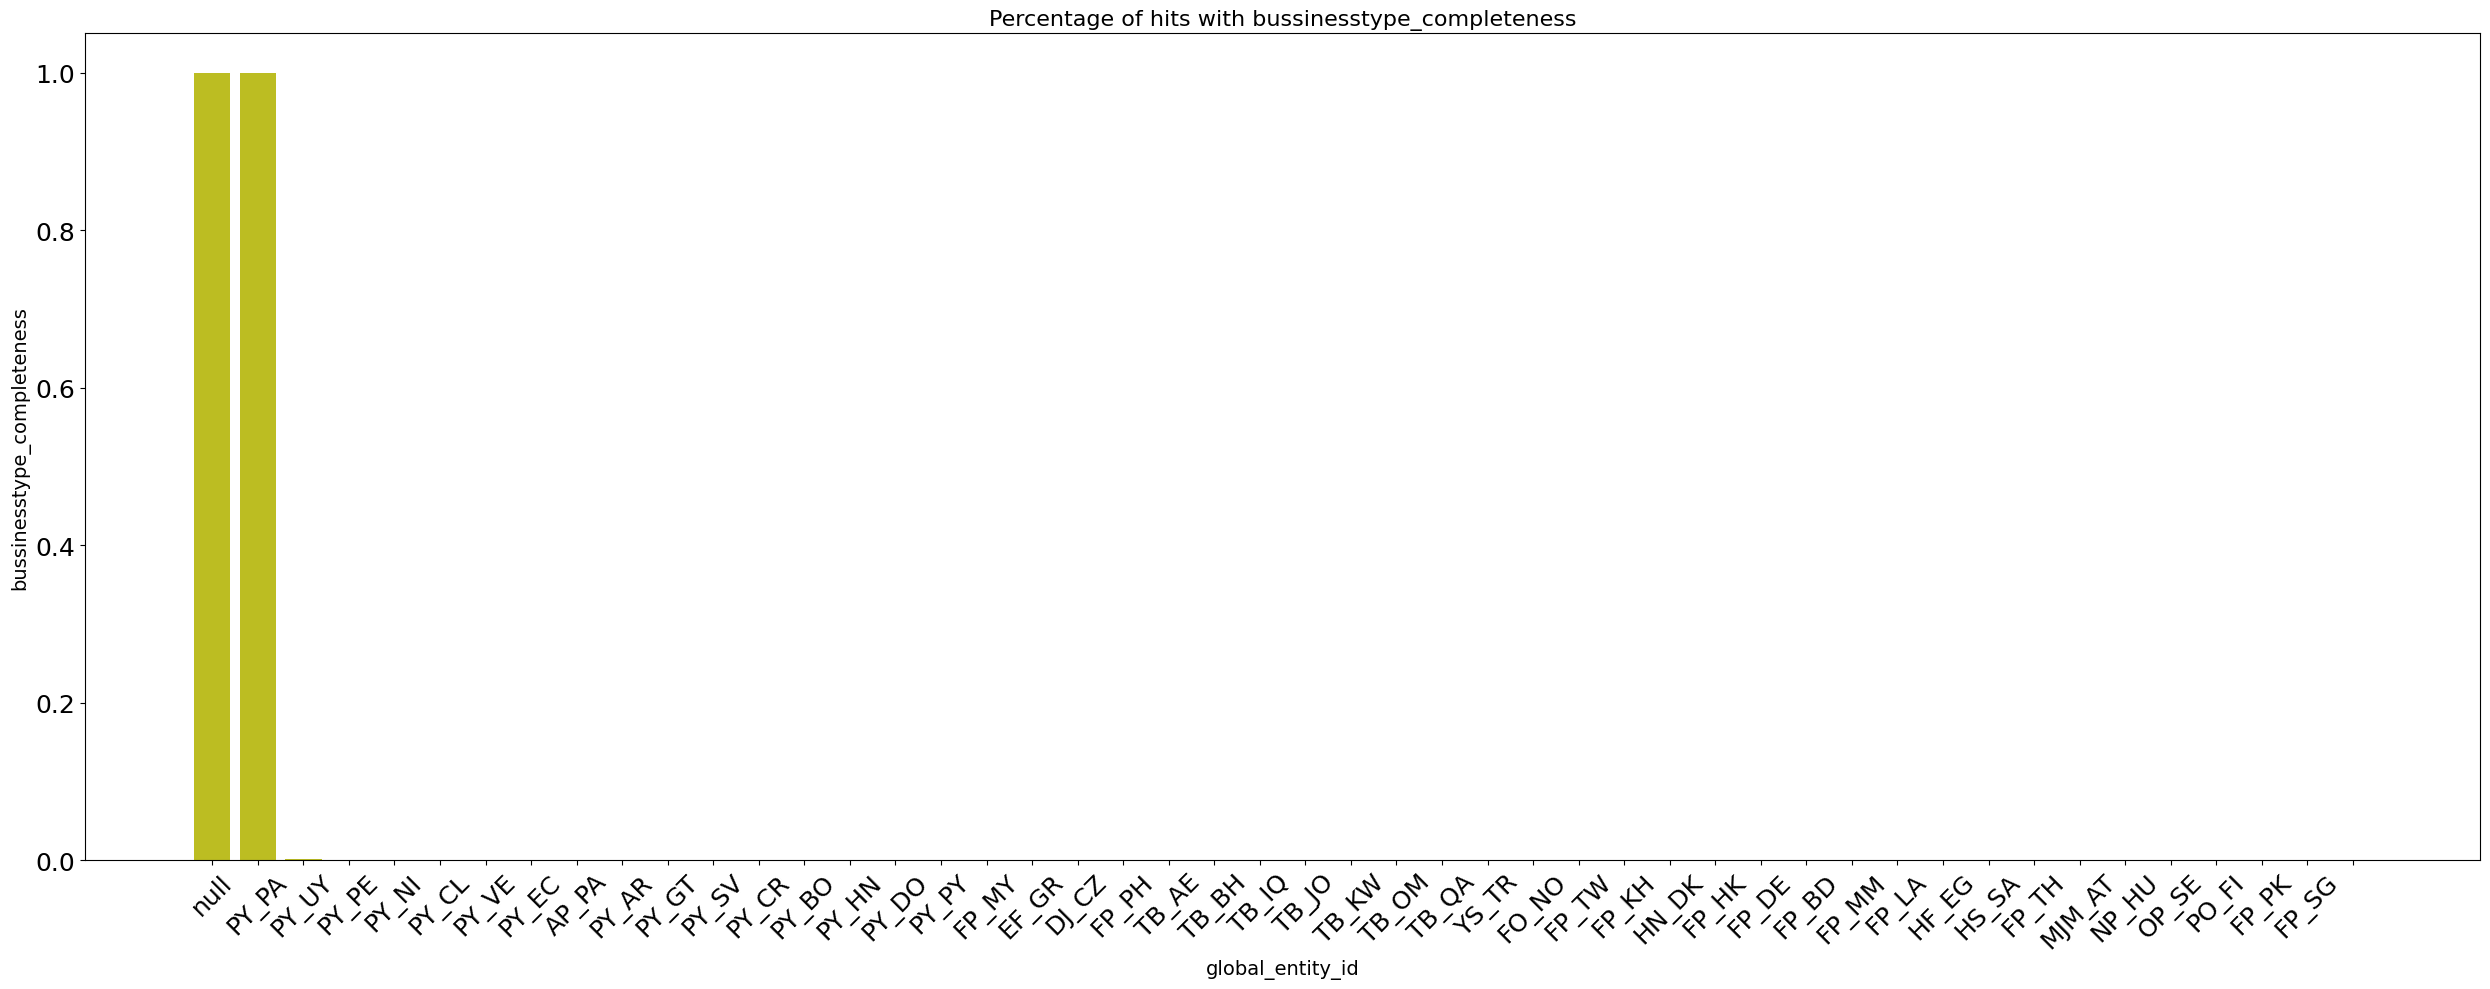

In [62]:
impression_data_completeness['entity_grouping'] = impression_data_completeness['global_entity_id'].str.split('_').str[0]
impression_data_completeness = impression_data_completeness.dropna(subset=['global_entity_id'])

cols = ['fee_completeness', 'quality_completeness', 'quantity_completeness', 
        'mov_completeness', 'deliverytime_completeness', 'bussinesstype_completeness']

impression_data_completeness = impression_data_completeness.sort_values(by = 'entity_grouping')

x_axis_column = 'global_entity_id'

# Extract x-axis data
x_data = impression_data_completeness[x_axis_column]

# Generate a colormap
num_cols = len(cols)
color_map = plt.cm.get_cmap('tab10')  

# Iterate through each column in cols and plot
for i, col in enumerate(cols):
    # Sort data by the current column
    sorted_data = impression_data_completeness.sort_values(by=col, ascending = False)
    
    # Extract x-axis data
    x_data = sorted_data[x_axis_column]

    # Create a figure and axis for plotting
    fig, ax = plt.subplots()
    fig.set_size_inches(25, 10, forward=True)

    # Plot the data with dynamically assigned color
    color = color_map(i / num_cols)  
    ax.bar(x_data, sorted_data[col], color=color)
    
    ax.set_xlabel(x_axis_column, fontsize=14)
    ax.set_ylabel(col, fontsize=14)
    ax.set_title(f'Percentage of hits with {col}', fontsize=16)
    
    plt.xticks(rotation=45, fontsize=18)
    plt.yticks(fontsize=18)
    
    # Show plot
    plt.tight_layout()  
    plt.show()
    

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_2321/3863114794.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10')


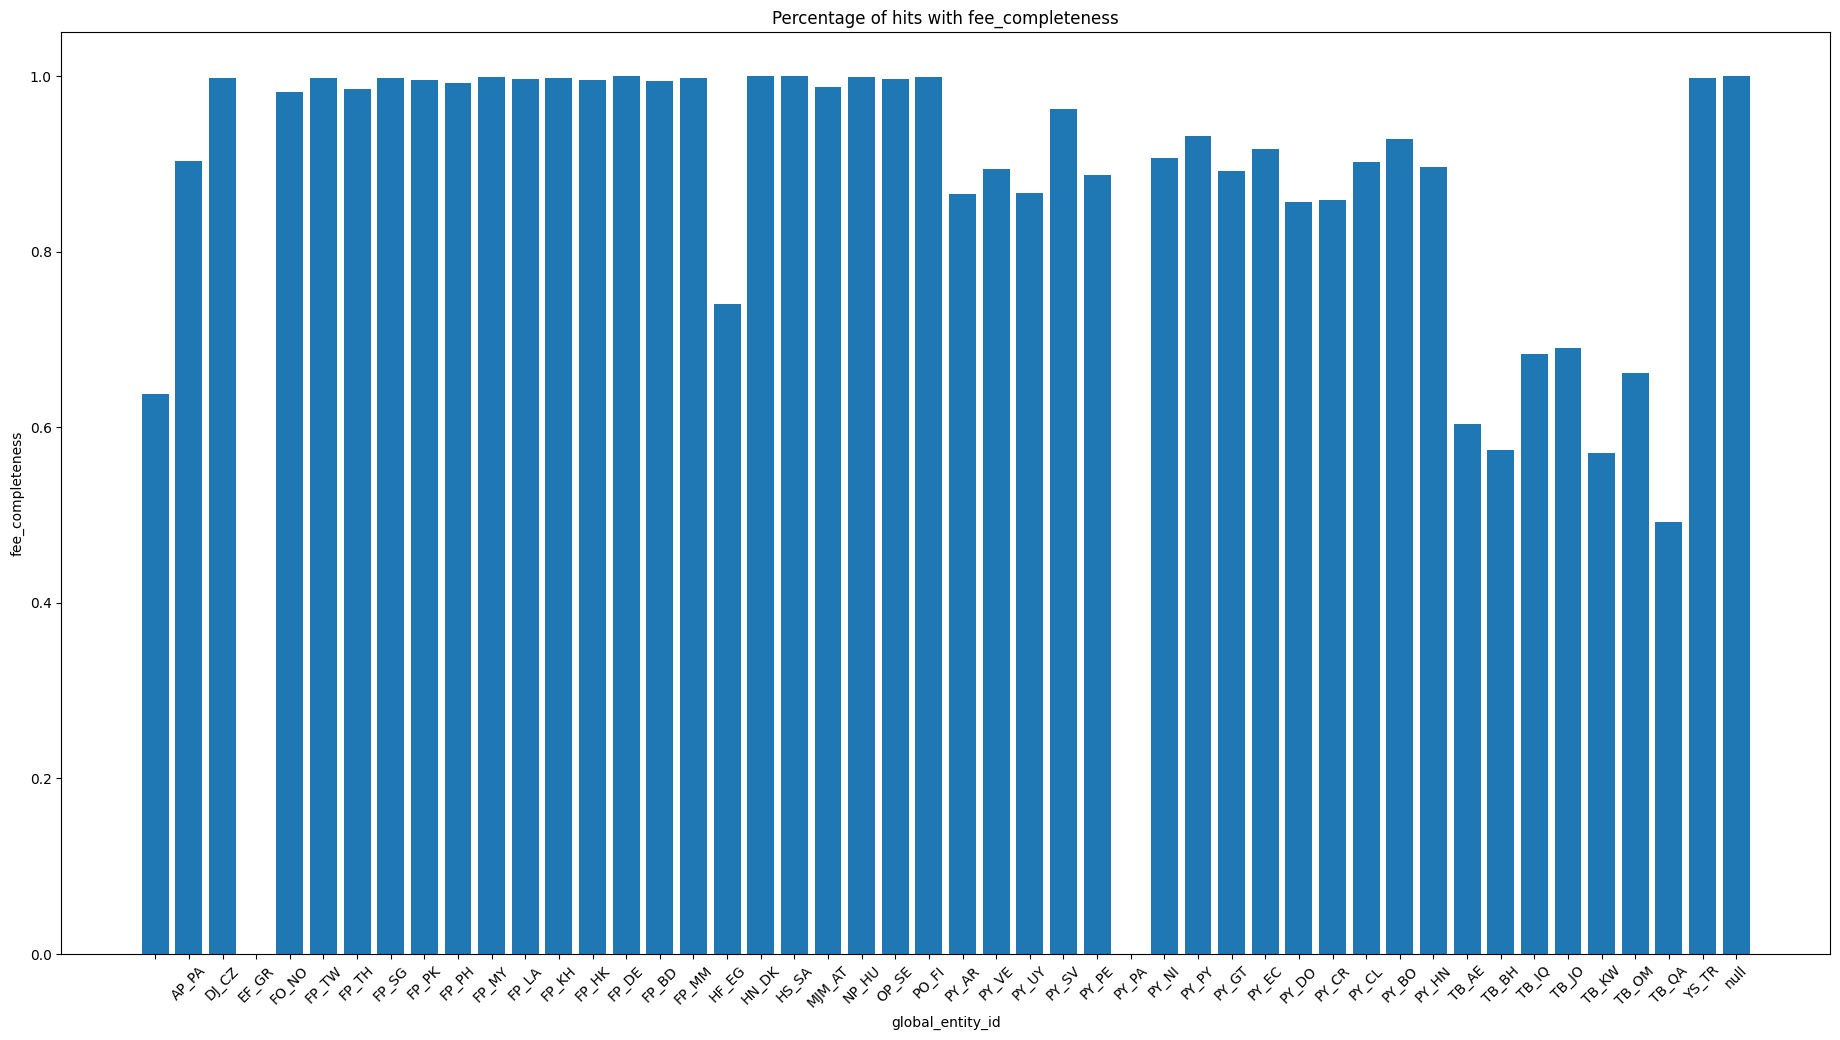

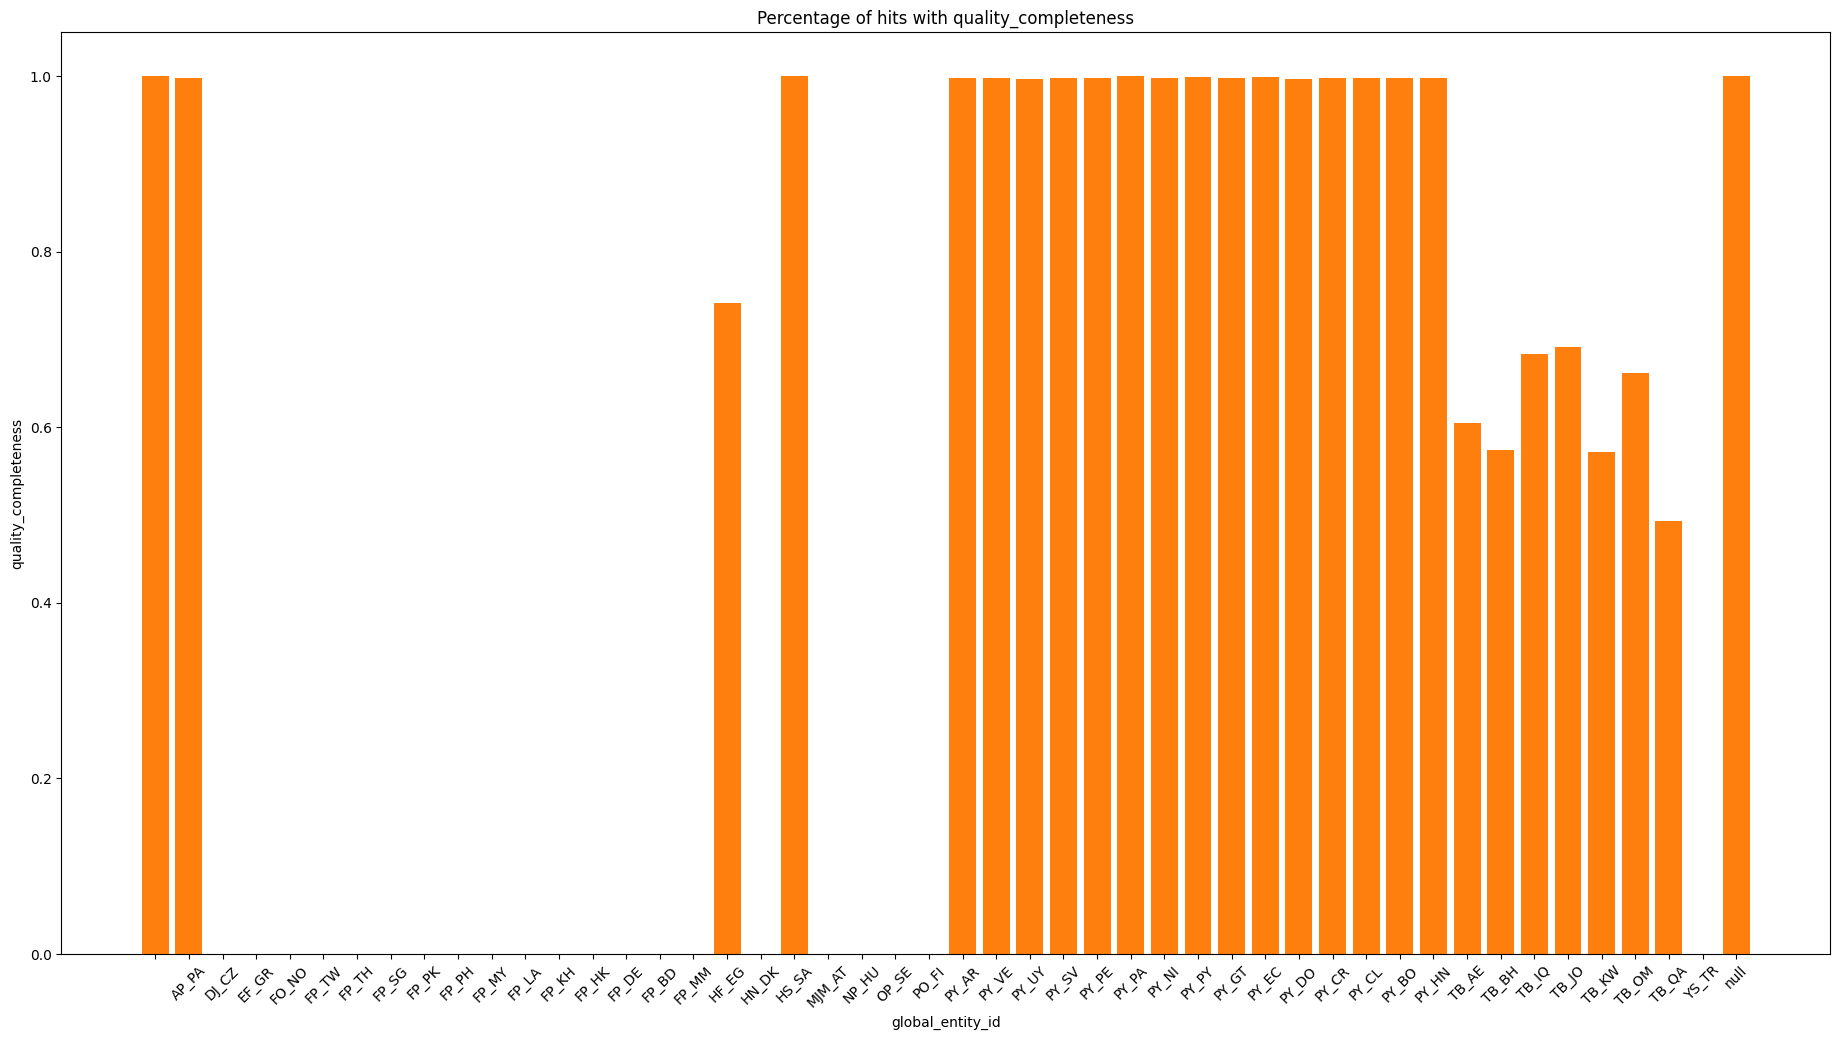

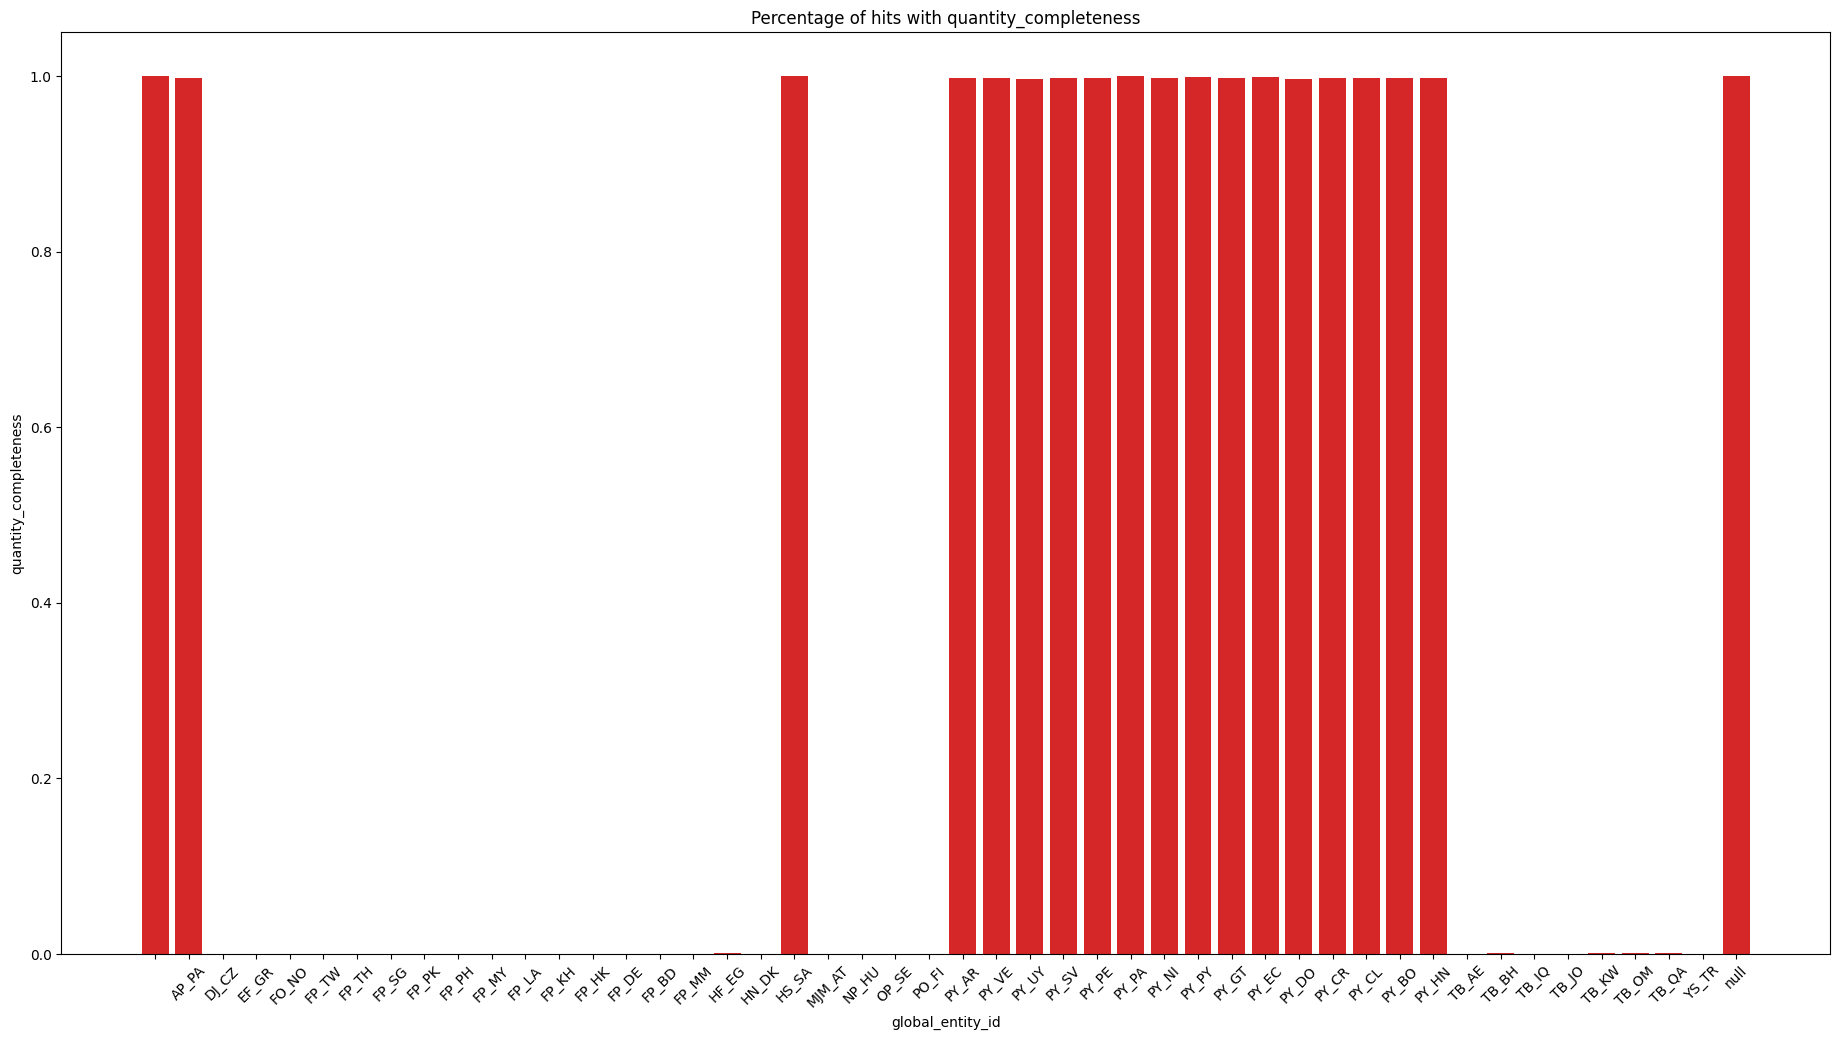

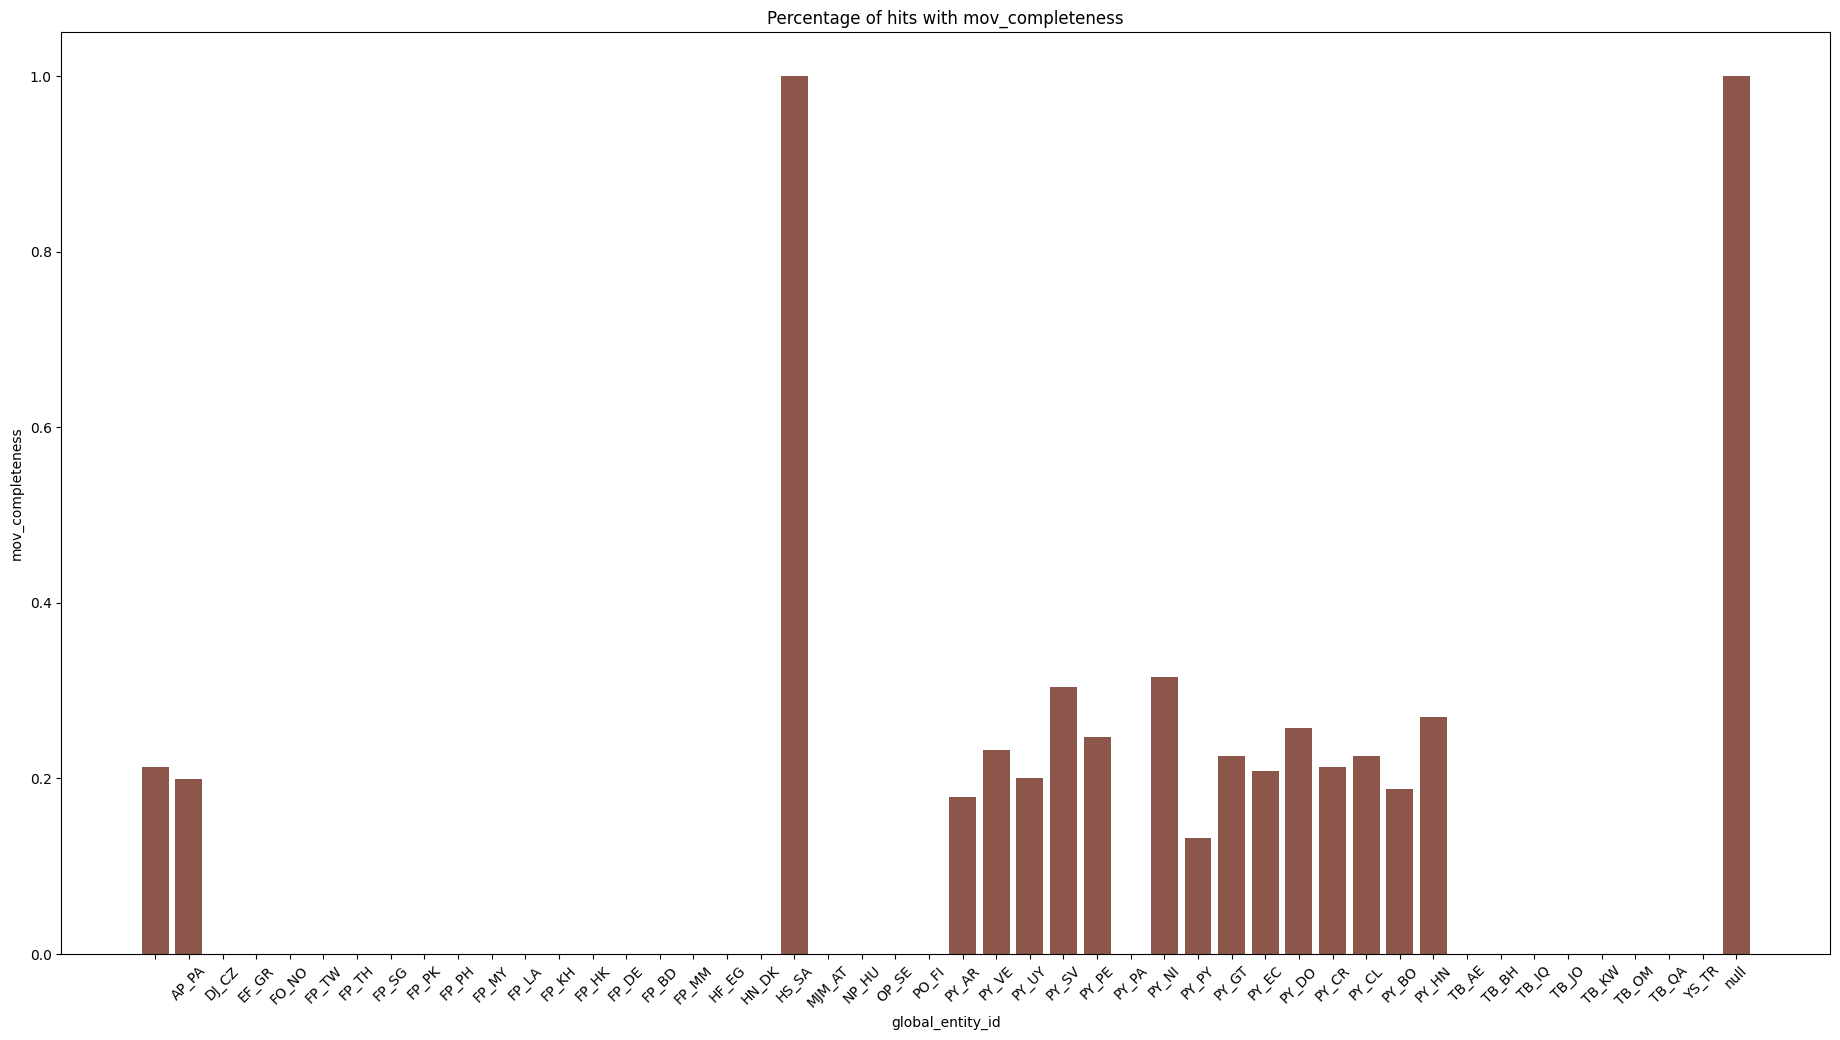

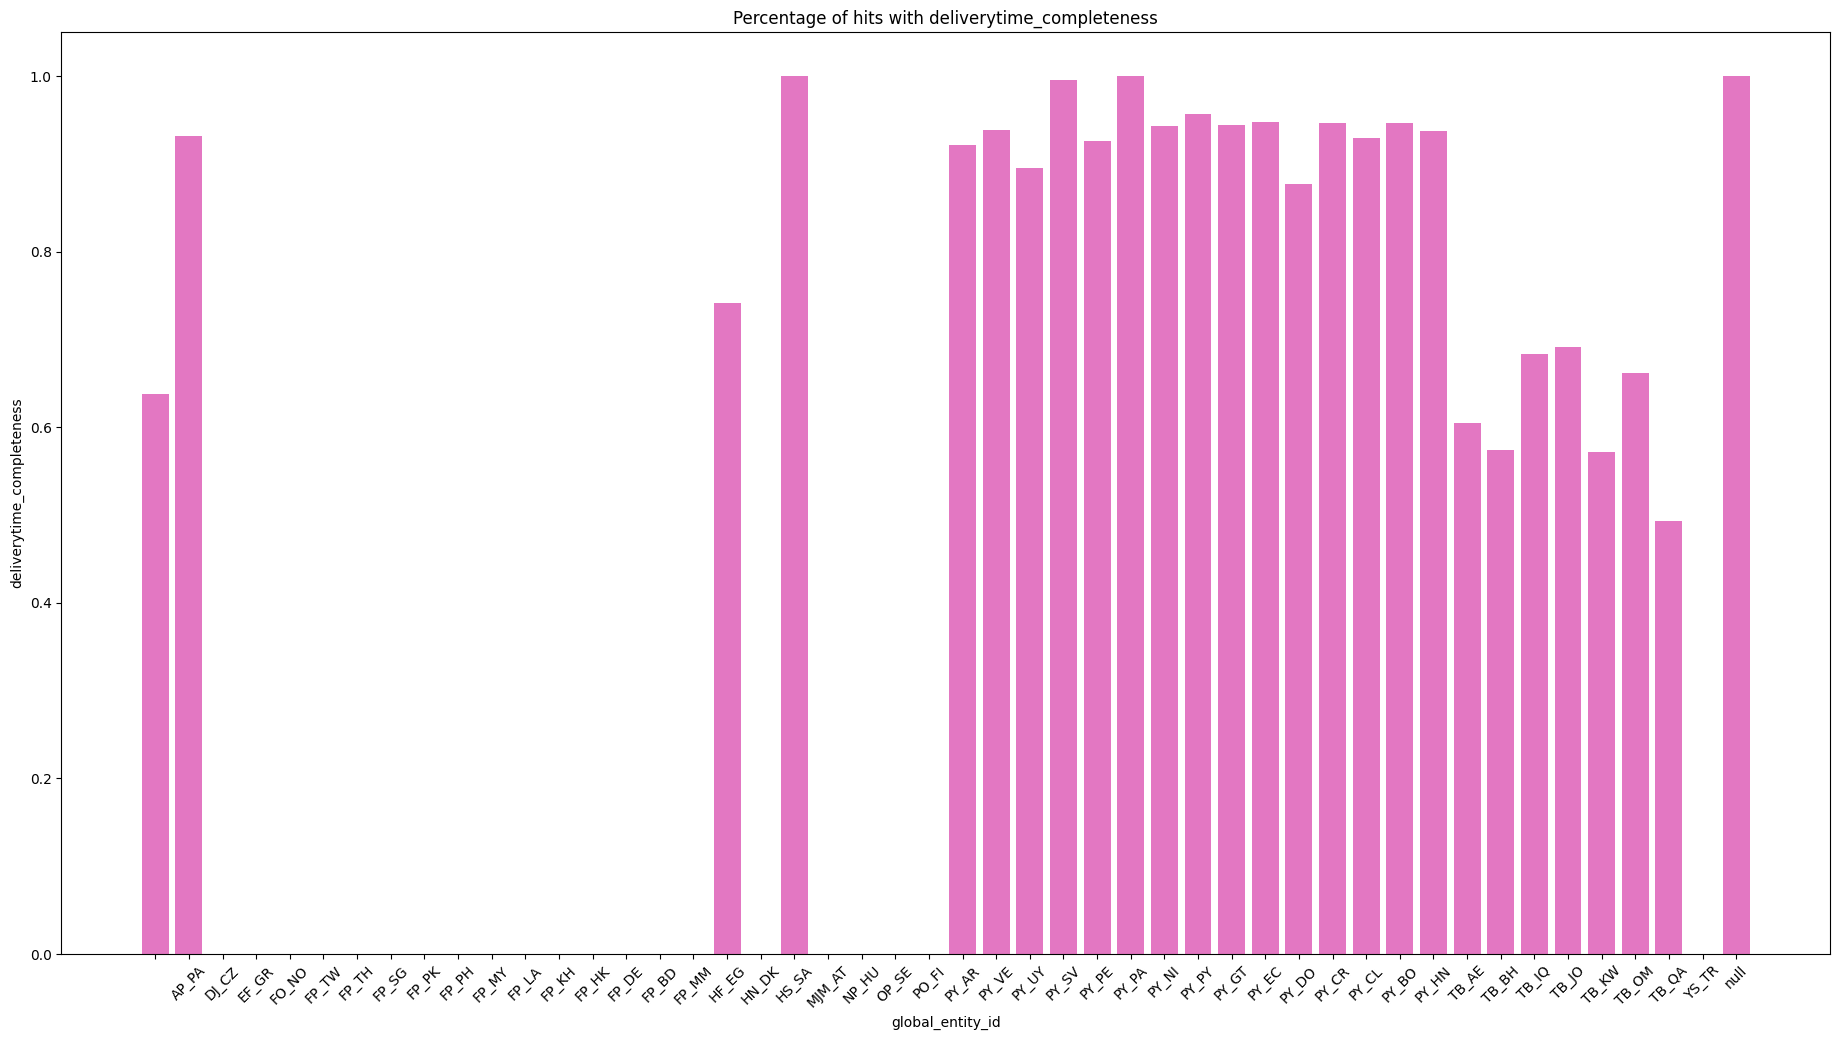

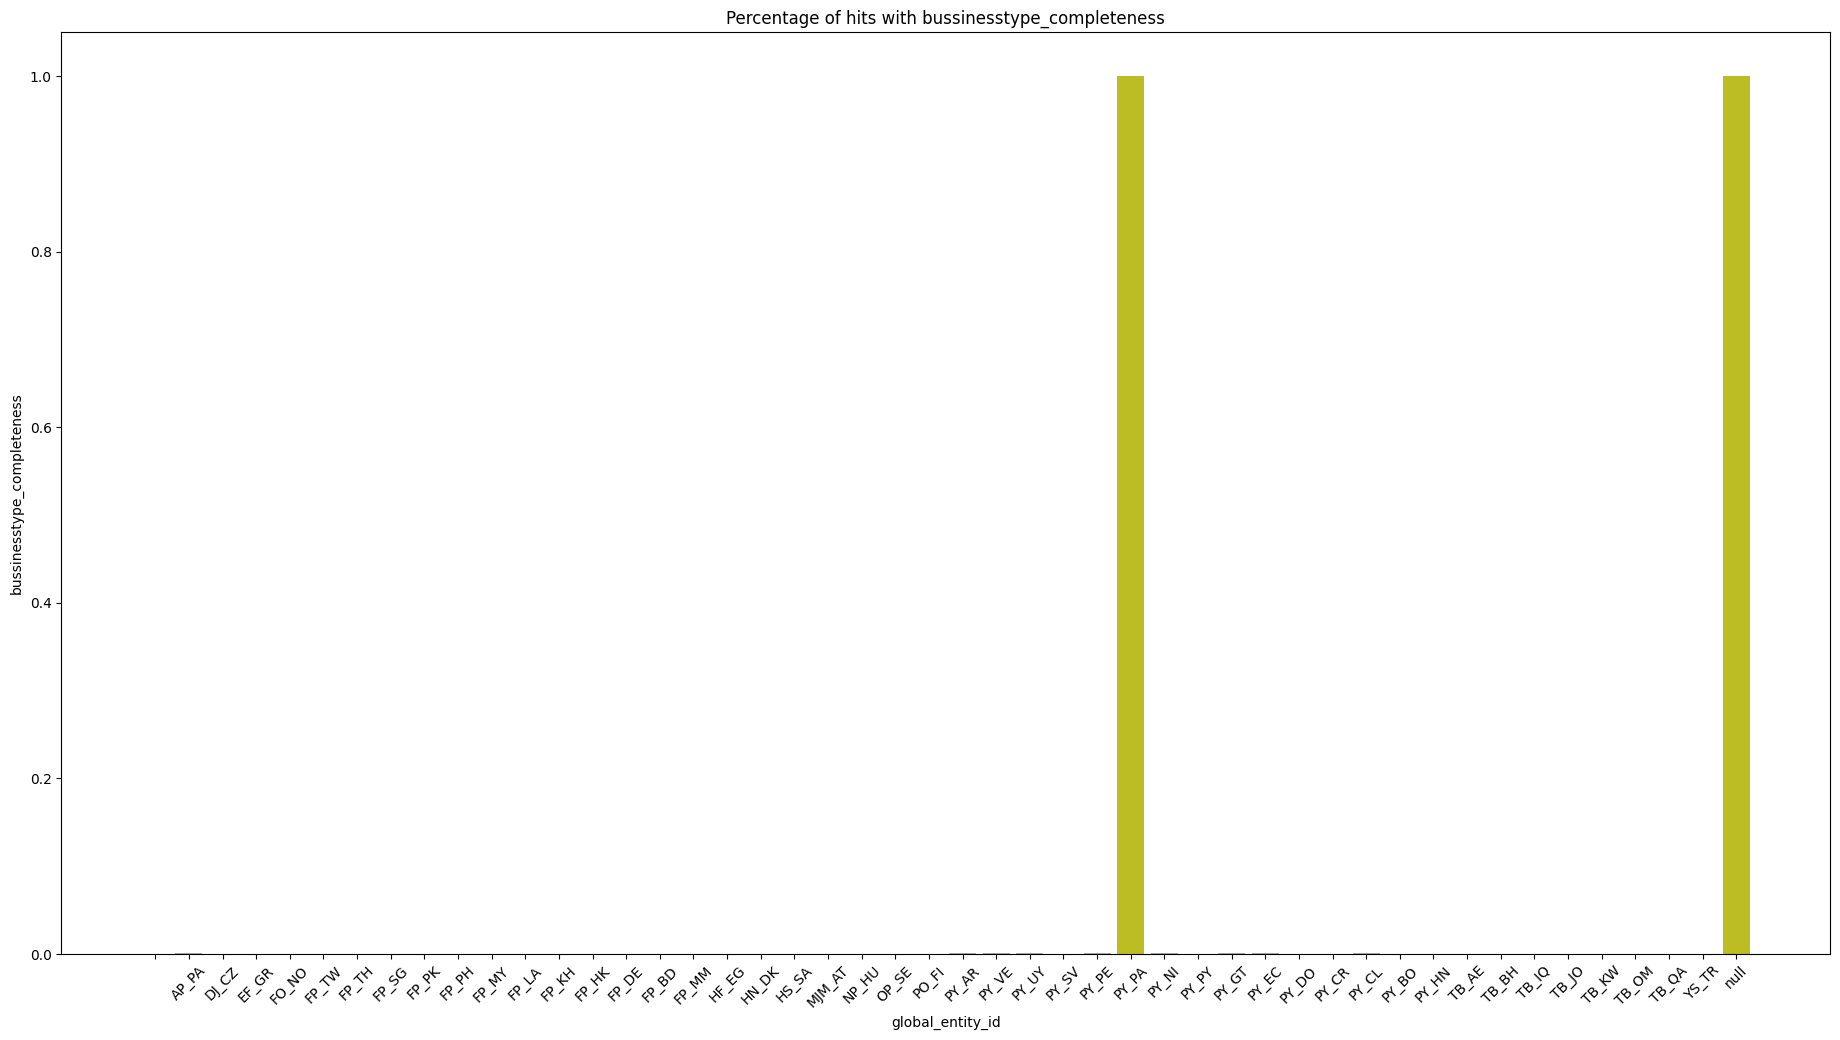

In [48]:
impression_data_completeness['entity_grouping'] = impression_data_completeness['global_entity_id'].str.split('_').str[0]
impression_data_completeness = impression_data_completeness.dropna(subset=['global_entity_id'])

# Assuming 'test' is your DataFrame and 'cols' is your list of columns
cols = ['fee_completeness', 'quality_completeness', 'quantity_completeness', 
        'mov_completeness', 'deliverytime_completeness', 'bussinesstype_completeness']

impression_data_completeness = impression_data_completeness.sort_values(by = 'entity_grouping')

x_axis_column = 'global_entity_id'

# Extract x-axis data
x_data = impression_data_completeness[x_axis_column]

# Generate a colormap
num_cols = len(cols)
color_map = plt.cm.get_cmap('tab10')  

# Iterate through each column in cols and plot
for i, col in enumerate(cols):
    # Create a figure and axis for plotting
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5, forward=True)

    # Plot the data with dynamically assigned color
    color = color_map(i / num_cols)  # Use colormap to get a color
    ax.bar(x_data, impression_data_completeness[col], color=color)
    
    # Set labels and title
    ax.set_xlabel(x_axis_column)
    ax.set_ylabel(col)
    ax.set_title(f'Percentage of hits with {col}')
    
    # Optionally, rotate x-axis labels if needed
    plt.xticks(rotation=45)
    
    # Show plot
    plt.tight_layout()  # Adjust layout for better presentation
    plt.show()

In [8]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)
start_date = '2024-06-01'
end_date = '2024-06-01'

query = f"""
with impression_data as (
  SELECT 
    partition_date,
    COALESCE(global_entity_id, v1.value) AS global_entity_id,
    COALESCE(platform, v2.value) AS platform,
    COALESCE(sessionId, v3.value) AS perseus_session_id,
    COALESCE(hitMatchId, v4.value) AS perseus_hit_match_id,
    COALESCE(transactionId, v5.value) AS orderId,
    COALESCE(shopListType, v6.value) AS shopListType,
    COALESCE(shopId, v7.value) AS shopId,
    COALESCE(shopPosition, v8.value) AS shopPosition,
    COALESCE(eventOrigin, v9.value) AS eventOrigin,
    COALESCE(v10.value, '') AS shopRatingQuality,
    COALESCE(v11.value, '') AS businessType,
    COALESCE(v12.value, '') AS shopRatingQuantity,
    COALESCE(v13.value, '') AS shopMinimumOrderValue,
    COALESCE(v14.value, '') AS vendor_delivery_fee,
    COALESCE(v15.value, '') AS shopDeliveryTime
  FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
  LEFT JOIN UNNEST(eventVariables) v1 ON v1.name IN ('globalEntityId')
  LEFT JOIN UNNEST(eventVariables) v2 ON v2.name IN ('eventPlatform')
  LEFT JOIN UNNEST(eventVariables) v3 ON v3.name IN ('perseusSessionId')
  LEFT JOIN UNNEST(eventVariables) v4 ON v4.name IN ('perseusHitMatchId')
  LEFT JOIN UNNEST(eventVariables) v5 ON v5.name IN ('transactionId', 'orderId')
  LEFT JOIN UNNEST(eventVariables) v6 ON v6.name IN ('shopListType')
  LEFT JOIN UNNEST(eventVariables) v7 ON v7.name IN ('shopId')
  LEFT JOIN UNNEST(eventVariables) v8 ON v8.name IN ('shopPosition')
  LEFT JOIN UNNEST(eventVariables) v9 ON v9.name IN ('origin')
  LEFT JOIN UNNEST(eventVariables) v10 ON v10.name IN ('shopRatingQuality')
  LEFT JOIN UNNEST(eventVariables) v11 ON v11.name IN ('businessType')
  LEFT JOIN UNNEST(eventVariables) v12 ON v12.name IN ('shopRatingQuantity')
  LEFT JOIN UNNEST(eventVariables) v13 ON v13.name IN ('shopMinimumOrderValue')
  LEFT JOIN UNNEST(eventVariables) v14 ON v14.name IN ('shopDeliveryFee', 'vendorDeliveryFee')
  LEFT JOIN UNNEST(eventVariables) v15 ON v15.name IN ('shopDeliveryTime')
  WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
    AND eventAction = 'shop_impressions.loaded'
),
aggregation as (
SELECT 
  global_entity_id,
  count(distinct perseus_session_id) as total_sessions,
  count(distinct perseus_hit_match_id) as total_hits,
  count(distinct case when cast(regexp_extract(vendor_delivery_fee,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as fee_hits,
  count(distinct case when cast(regexp_extract(shopRatingQuality,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as quality_hits,
  count(distinct case when cast(regexp_extract(shopRatingQuantity,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as quantity_hits,
  count(distinct case when cast(regexp_extract(shopMinimumOrderValue,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as mov_hits,
  count(distinct case when cast(regexp_extract(shopDeliveryTime,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as delivery_time_hits,
  count(distinct case when businessType is not null then perseus_hit_match_id end) as business_type_hits
FROM impression_data
GROUP BY 1
)
select a.*,
       1.00 * (fee_hits / total_hits) fee_completeness,
       1.00 * (quality_hits / total_hits) quality_completeness,
       1.00 * (quantity_hits / total_hits ) quantity_completeness,
       1.00 * (mov_hits / total_hits ) mov_completeness,
       1.00 * (delivery_time_hits / total_hits ) deliverytime_completeness,
       1.00 * (business_type_hits / total_hits ) bussinesstype_completeness
from aggregation a
"""

impression_data_completeness = client.query(query).to_dataframe()

<>:42: SyntaxWarning: invalid escape sequence '\d'
<>:42: SyntaxWarning: invalid escape sequence '\d'
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_96015/3167237812.py:42: SyntaxWarning: invalid escape sequence '\d'
  WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [14]:
impression_data_completeness['entity_grouping'] = impression_data_completeness['global_entity_id'].str.split('_').str[0]
impression_data_completeness
impression_data_completeness = impression_data_completeness.dropna(subset=['global_entity_id'])


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_96015/1781327004.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10')  # Choose a colormap (e.g., 'tab10' for 10 distinct colors)


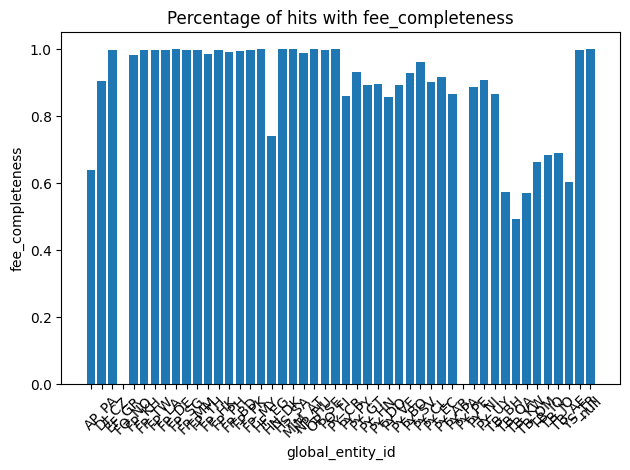

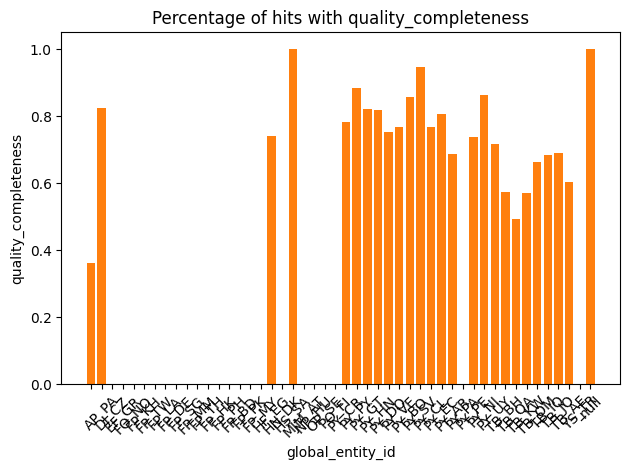

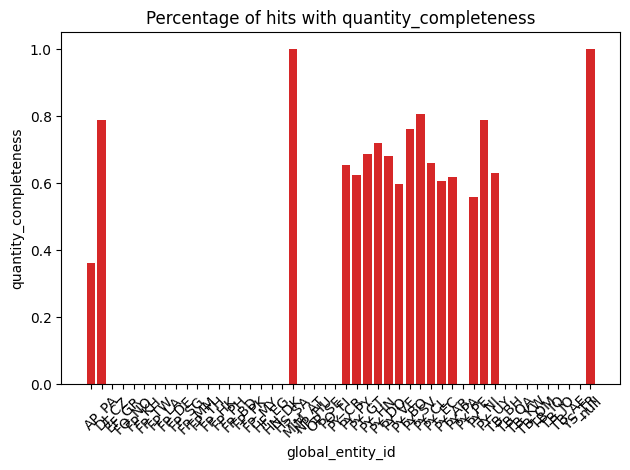

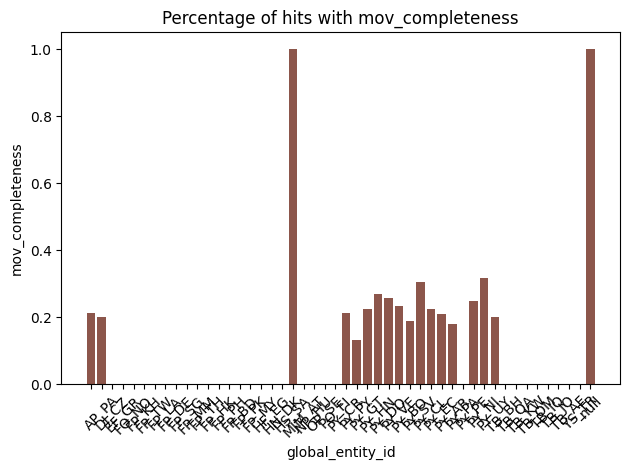

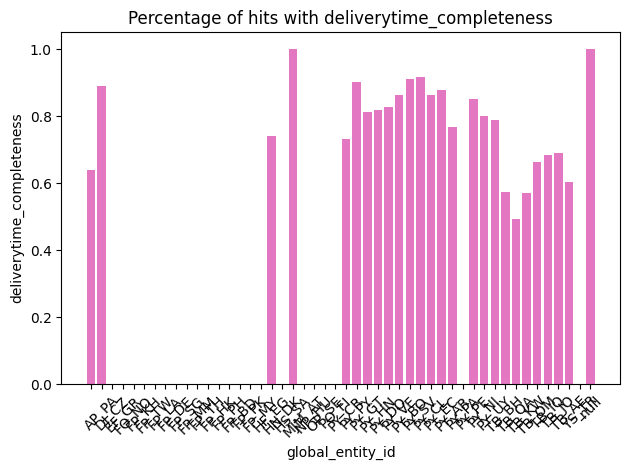

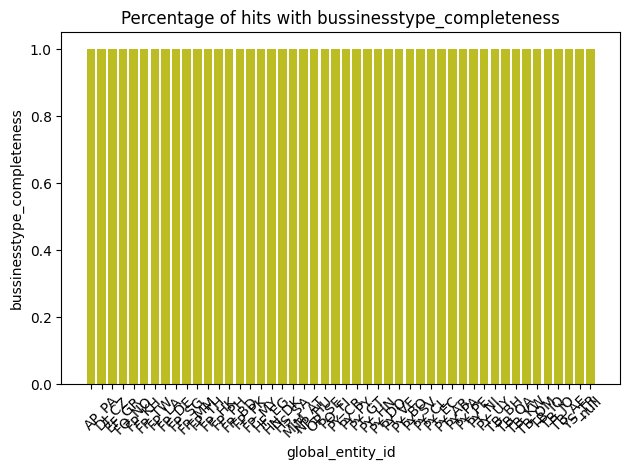

In [15]:
# Assuming 'test' is your DataFrame and 'cols' is your list of columns
cols = ['fee_completeness', 'quality_completeness', 'quantity_completeness', 
        'mov_completeness', 'deliverytime_completeness', 'bussinesstype_completeness']

impression_data_completeness = impression_data_completeness.sort_values(by = 'entity_grouping')

# Assuming 'global_entity_id' is the x-axis column
x_axis_column = 'global_entity_id'

# Extract x-axis data
x_data = impression_data_completeness[x_axis_column]

# Generate a colormap
num_cols = len(cols)
color_map = plt.cm.get_cmap('tab10')  # Choose a colormap (e.g., 'tab10' for 10 distinct colors)

# Iterate through each column in cols and plot
for i, col in enumerate(cols):
    # Create a figure and axis for plotting
    fig, ax = plt.subplots()
    
    # Plot the data with dynamically assigned color
    color = color_map(i / num_cols)  # Use colormap to get a color
    ax.bar(x_data, impression_data_completeness[col], color=color)
    
    # Set labels and title
    ax.set_xlabel(x_axis_column)
    ax.set_ylabel(col)
    ax.set_title(f'Percentage of hits with {col}')
    
    # Optionally, rotate x-axis labels if needed
    plt.xticks(rotation=45)
    
    # Show plot
    plt.tight_layout()  # Adjust layout for better presentation
    plt.show()

In [17]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)
start_date = '2024-06-01'
end_date = '2024-06-07'

query = f"""
with impression_data as (
  SELECT 
    partition_date,
    COALESCE(global_entity_id, v1.value) AS global_entity_id,
    COALESCE(platform, v2.value) AS platform,
    COALESCE(sessionId, v3.value) AS perseus_session_id,
    COALESCE(hitMatchId, v4.value) AS perseus_hit_match_id,
    COALESCE(transactionId, v5.value) AS orderId,
    COALESCE(shopListType, v6.value) AS shopListType,
    COALESCE(shopId, v7.value) AS shopId,
    COALESCE(shopPosition, v8.value) AS shopPosition,
    COALESCE(eventOrigin, v9.value) AS eventOrigin,
    COALESCE(v10.value, '') AS shopRatingQuality,
    COALESCE(v11.value, '') AS businessType,
    COALESCE(v12.value, '') AS shopRatingQuantity,
    COALESCE(v13.value, '') AS shopMinimumOrderValue,
    COALESCE(v14.value, '') AS vendor_delivery_fee,
    COALESCE(v15.value, '') AS shopDeliveryTime
  FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
  LEFT JOIN UNNEST(eventVariables) v1 ON v1.name IN ('globalEntityId')
  LEFT JOIN UNNEST(eventVariables) v2 ON v2.name IN ('eventPlatform')
  LEFT JOIN UNNEST(eventVariables) v3 ON v3.name IN ('perseusSessionId')
  LEFT JOIN UNNEST(eventVariables) v4 ON v4.name IN ('perseusHitMatchId')
  LEFT JOIN UNNEST(eventVariables) v5 ON v5.name IN ('transactionId', 'orderId')
  LEFT JOIN UNNEST(eventVariables) v6 ON v6.name IN ('shopListType')
  LEFT JOIN UNNEST(eventVariables) v7 ON v7.name IN ('shopId')
  LEFT JOIN UNNEST(eventVariables) v8 ON v8.name IN ('shopPosition')
  LEFT JOIN UNNEST(eventVariables) v9 ON v9.name IN ('origin')
  LEFT JOIN UNNEST(eventVariables) v10 ON v10.name IN ('shopRatingQuality')
  LEFT JOIN UNNEST(eventVariables) v11 ON v11.name IN ('businessType')
  LEFT JOIN UNNEST(eventVariables) v12 ON v12.name IN ('shopRatingQuantity')
  LEFT JOIN UNNEST(eventVariables) v13 ON v13.name IN ('shopMinimumOrderValue')
  LEFT JOIN UNNEST(eventVariables) v14 ON v14.name IN ('shopDeliveryFee', 'vendorDeliveryFee')
  LEFT JOIN UNNEST(eventVariables) v15 ON v15.name IN ('shopDeliveryTime')
  WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
    AND eventAction = 'shop_impressions.loaded'
),
aggregation as (
SELECT 
  global_entity_id,
  CASE 
  WHEN STRPOS(global_entity_id, '_') > 0 THEN 
    SUBSTR(global_entity_id, 1, STRPOS(global_entity_id, '_') - 1)
  ELSE 
    null
  END AS entity_grouping,
  partition_date,
  count(distinct perseus_session_id) as total_sessions,
  count(distinct perseus_hit_match_id) as total_hits,
  count(distinct case when cast(regexp_extract(vendor_delivery_fee,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as fee_hits,
  count(distinct case when cast(regexp_extract(shopRatingQuality,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as quality_hits,
  count(distinct case when cast(regexp_extract(shopRatingQuantity,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as quantity_hits,
  count(distinct case when cast(regexp_extract(shopMinimumOrderValue,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as mov_hits,
  count(distinct case when cast(regexp_extract(shopDeliveryTime,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as delivery_time_hits,
  count(distinct case when businessType is not null then perseus_hit_match_id end) as business_type_hits
FROM impression_data
GROUP BY 1,2,3
)
select a.*,
       1.00 * (fee_hits / total_hits) fee_completeness,
       1.00 * (quality_hits / total_hits) quality_completeness,
       1.00 * (quantity_hits / total_hits ) quantity_completeness,
       1.00 * (mov_hits / total_hits ) mov_completeness,
       1.00 * (delivery_time_hits / total_hits ) deliverytime_completeness,
       1.00 * (business_type_hits / total_hits ) bussinesstype_completeness
from aggregation a
"""

impression_data_time = client.query(query).to_dataframe()

<>:42: SyntaxWarning: invalid escape sequence '\d'
<>:42: SyntaxWarning: invalid escape sequence '\d'
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_96015/2482010450.py:42: SyntaxWarning: invalid escape sequence '\d'
  WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_96015/4236231072.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensures labels are not cut off


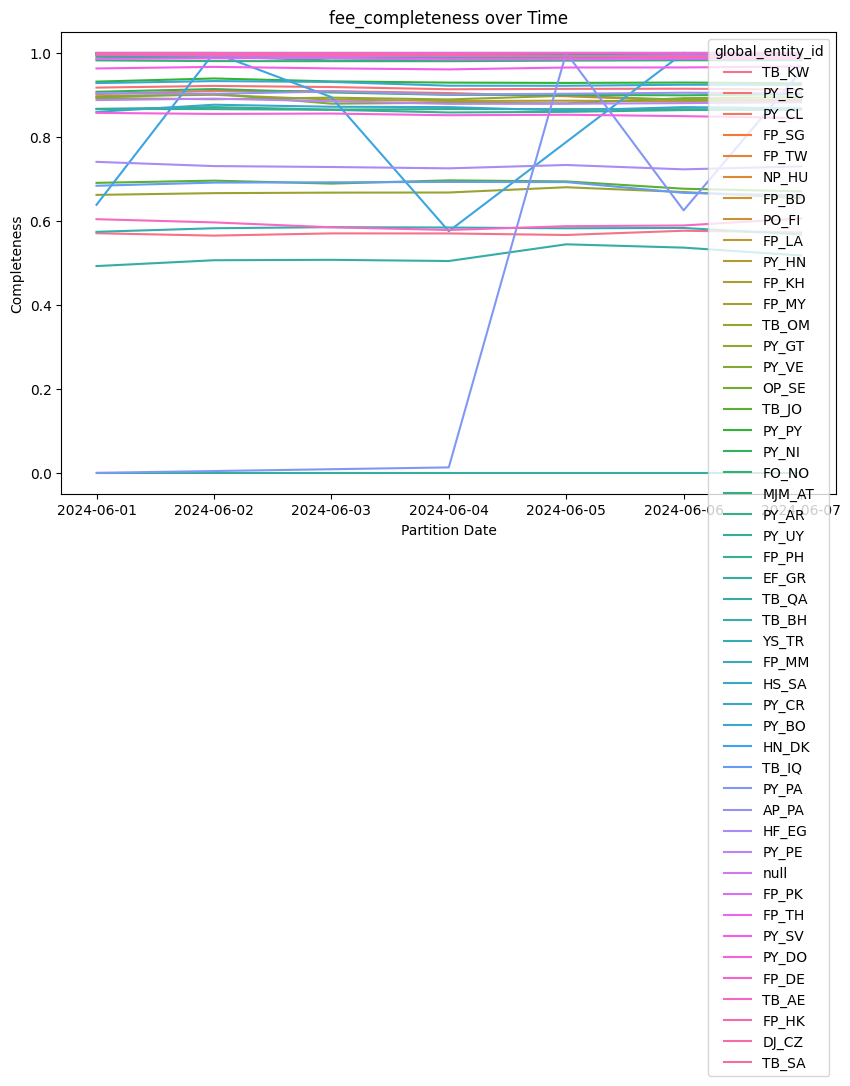

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_96015/4236231072.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensures labels are not cut off


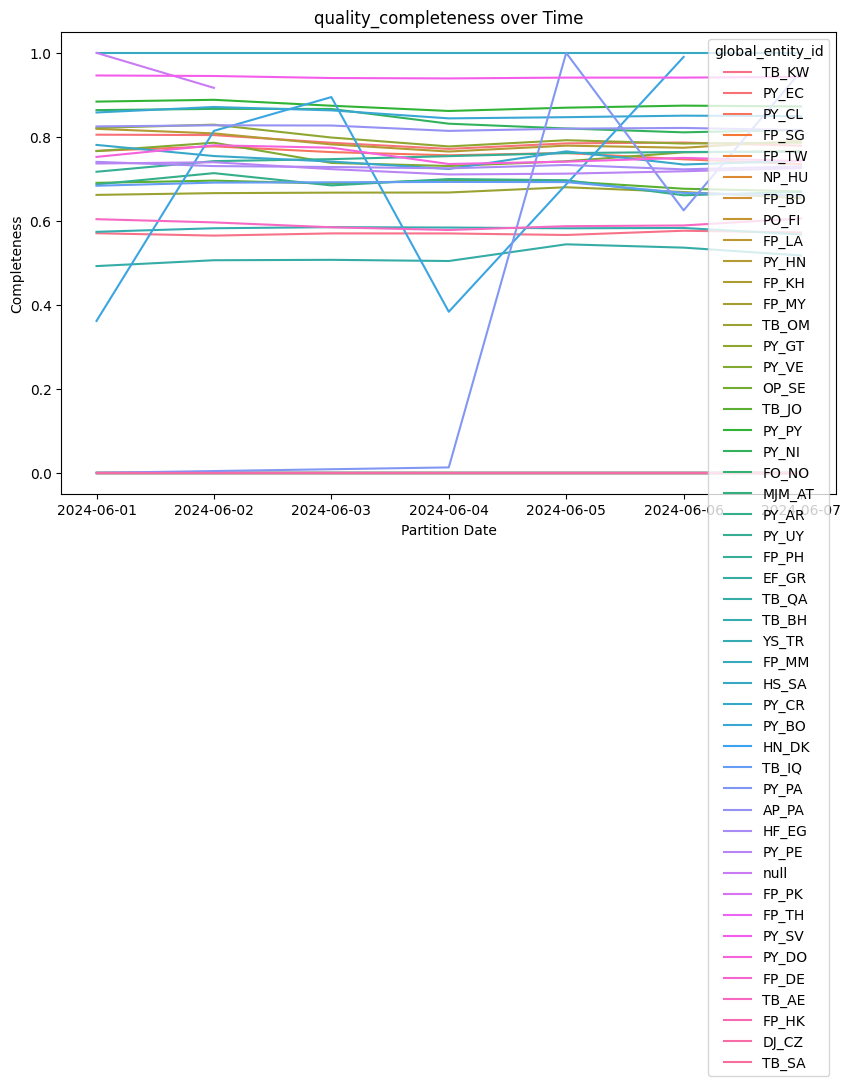

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_96015/4236231072.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensures labels are not cut off


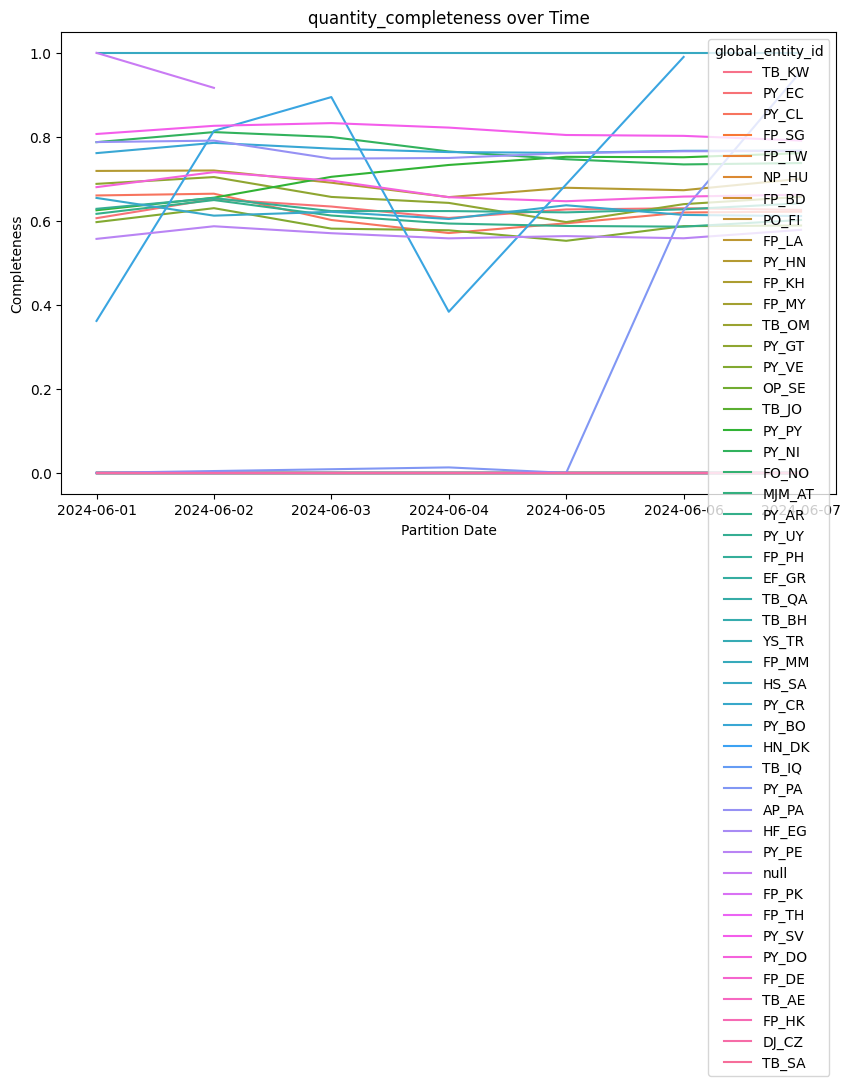

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_96015/4236231072.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensures labels are not cut off


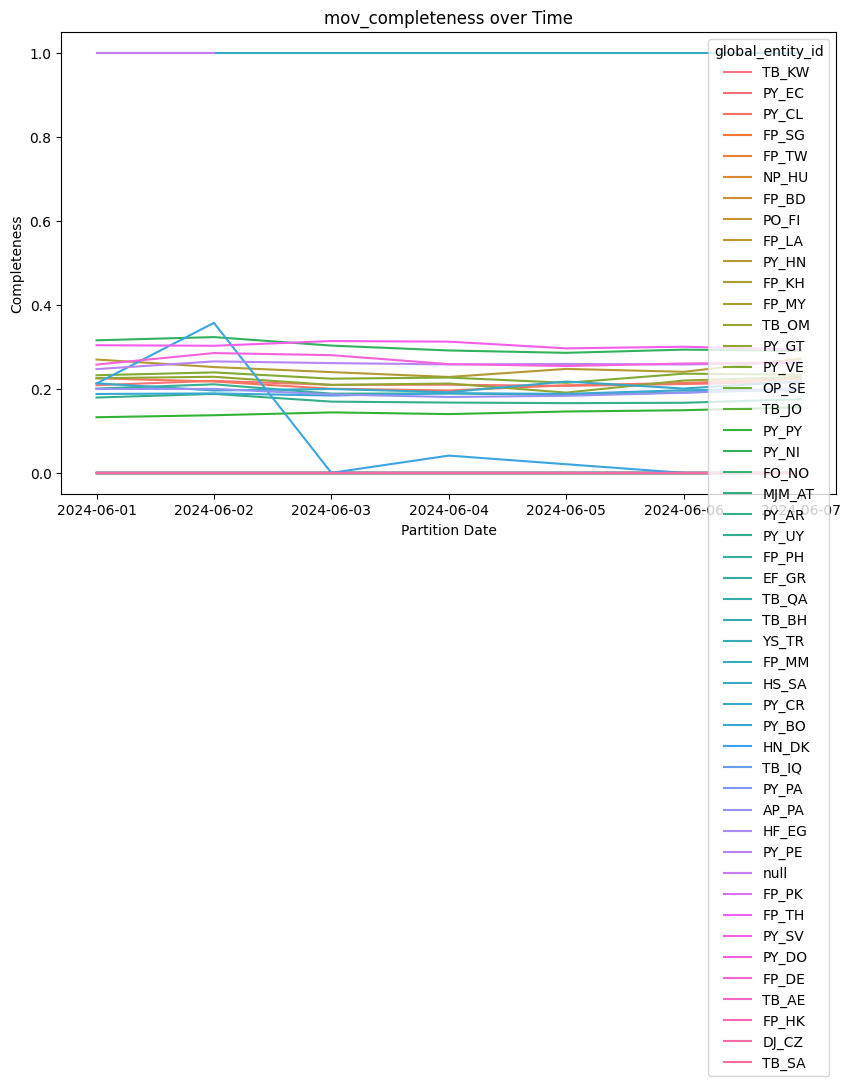

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_96015/4236231072.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensures labels are not cut off


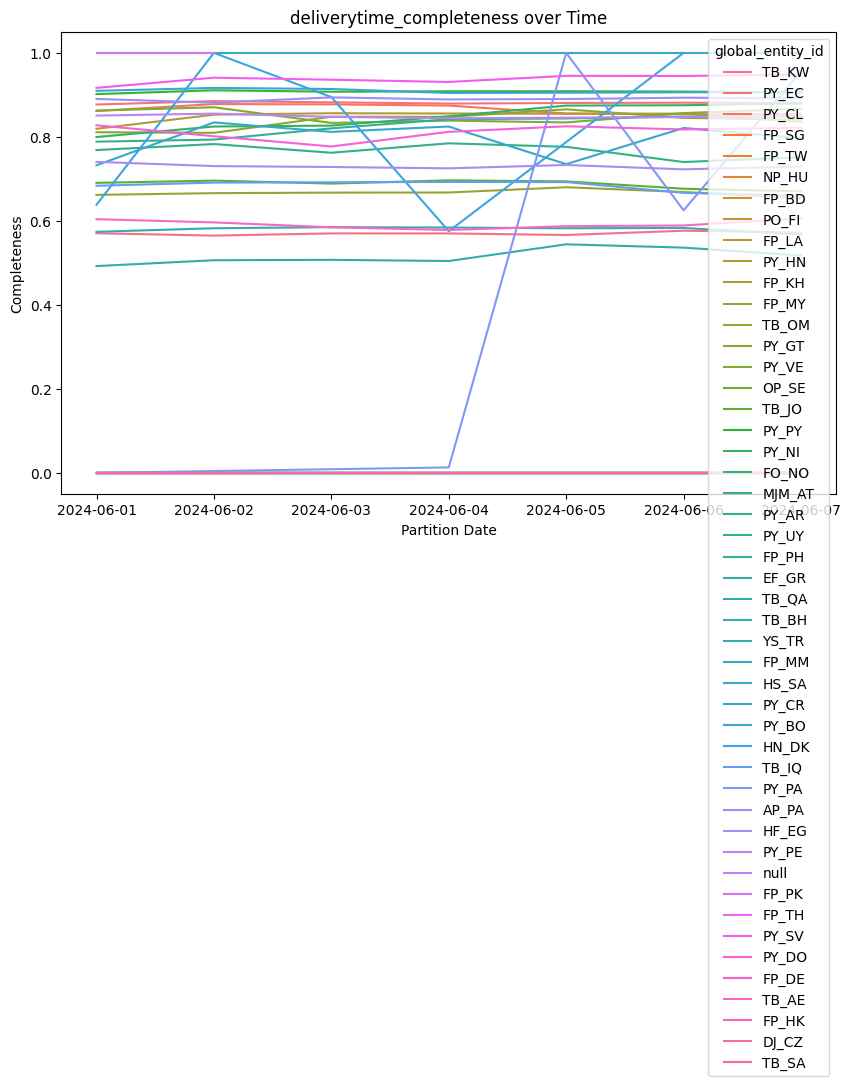

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_96015/4236231072.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensures labels are not cut off


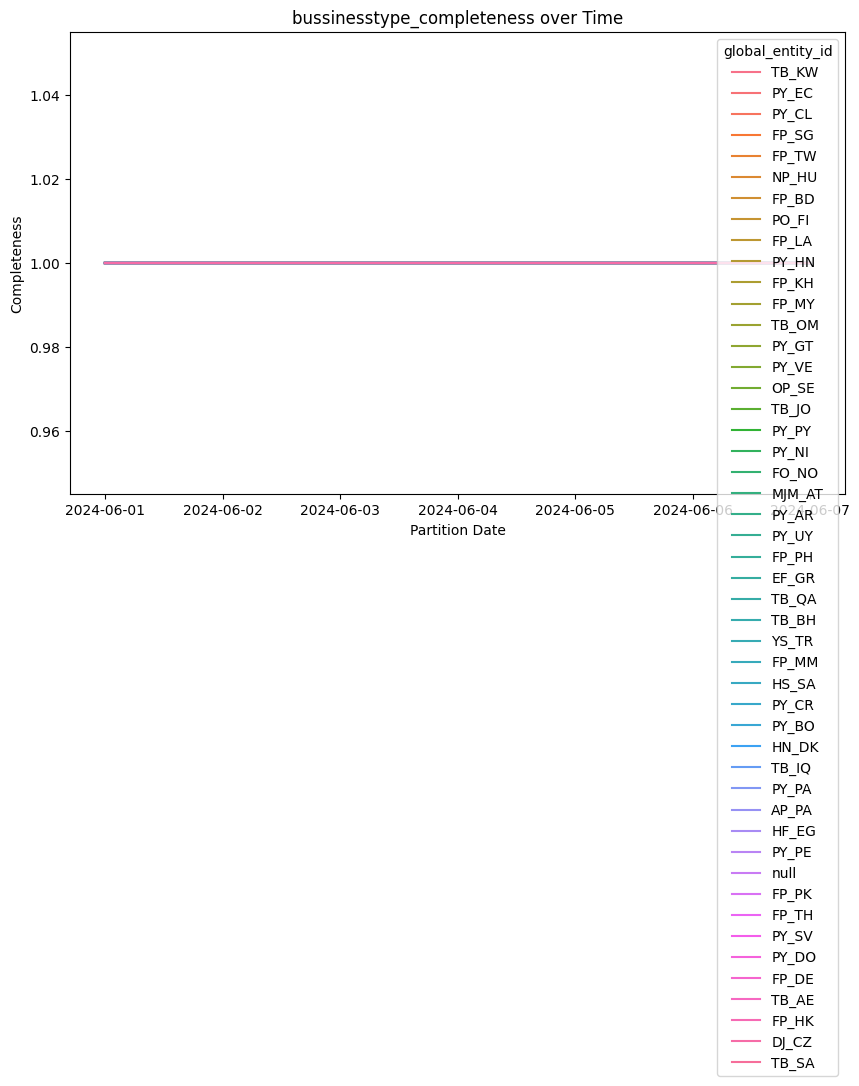

In [18]:
cols = ['fee_completeness', 'quality_completeness', 'quantity_completeness', 
        'mov_completeness', 'deliverytime_completeness', 'bussinesstype_completeness']

# Iterate through each column and create a separate figure for each
for col in cols:
    # Create a new figure for each column
    plt.figure(figsize=(10, 6))
    # Plot the data for the current column
    sns.lineplot(data=impression_data_time, x='partition_date', y=col, hue='global_entity_id')
    plt.title(f'{col} over Time')  # Set title for the current figure
    plt.xlabel('Partition Date')  # Label for x-axis
    plt.ylabel('Completeness')  # Label for y-axis
    plt.tight_layout()  # Ensures labels are not cut off
    plt.show()

In [19]:
# # define a few things (project id, start date etc.)
# project_id = "logistics-customer-staging"
# client = bigquery.Client(project = project_id)
# start_date = '2024-06-01'
# end_date = '2024-06-01'

# orders = f"""
#     with impression_data as (
#     SELECT 
#         country,
#         IFNULL(global_entity_id, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('globalEntityId'))) global_entity_id,
#         partition_date,
#         IFNULL(transactionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('transactionId','orderId'))) order_id 
#     FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
#     WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
#         AND eventAction = 'shop_impressions.loaded'
#         AND IFNULL(transactionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('transactionId','orderId'))) is not null
#     ), 
#     order_data as (
#     SELECT
#         country_name,
#         country_code,
#         entity_id,
#         created_date,
#         order_id
#     FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o
#     where created_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
#           AND order_id is not null
#     )
#     select  coalesce(od.entity_id, id.global_entity_id) entity_id,
#             count (distinct od.order_id) total_orders_sessions_m,
#             count (distinct id.order_id) total_orders_impressions_data
#     from impression_data id
#     left join order_data od on cast(id.global_entity_id as string) = cast(od.entity_id as string) and cast(id.order_id as string) = cast(od.order_id as string)
#     group by 1
#     """

# orders_data_match = client.query(orders).to_dataframe()

In [20]:
# orders_data_match

In [21]:
# # define a few things (project id, start date etc.)
# project_id = "logistics-customer-staging"
# client = bigquery.Client(project = project_id)
# start_date = '2024-06-01'
# end_date = '2024-06-01'

# orders = f"""
#     SELECT
#         country_name,
#         country_code,
#         entity_id,
#         created_date,
#         order_id
#     FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o
#     where created_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
#         AND order_id is not null
#     limit 5
#     """

# orders_data_match = client.query(orders).to_dataframe()

In [220]:
orders_data_match

,entity_id,total_orders_sessions_m,total_orders_impressions_data
0,ODR_MM,271,0
1,PY_AR,356487,0
2,ODR_DK,4,0
3,TB_JO,67545,0
4,FP_SG,77702,0
...,...,...,...
56,FP_MM,34061,0
57,DJ_CZ,32792,0
58,HS_SA,513268,0
59,FP_LA,7878,0


In [22]:
# # define a few things (project id, start date etc.)
# project_id = "logistics-customer-staging"
# client = bigquery.Client(project = project_id)
# start_date = '2024-06-01'
# end_date = '2024-06-01'

# orders = f"""
#     SELECT 
#         country,
#         IFNULL(global_entity_id, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('globalEntityId'))) global_entity_id,
#         partition_date,
#         IFNULL(transactionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('transactionId','orderId'))) order_id 
#     FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
#     WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
#         AND eventAction = 'shop_impressions.loaded'
#         AND ( IFNULL(transactionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('transactionId','orderId'))) is not null OR 
#             IFNULL(transactionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('transactionId','orderId'))) <> 'NA' )
#     group by 1,2
#     """

# orders_data_match = client.query(orders).to_dataframe()
# orders_data_match

In [23]:
# orders_data_match

In [19]:
# # define a few things (project id, start date etc.)
# project_id = "logistics-customer-staging"
# client = bigquery.Client(project = project_id)
# start_date = '2024-06-01'
# end_date = '2024-06-01'

# query = f"""
# WITH
# impression_data AS (
#   SELECT DISTINCT
#     partition_date,
#     IFNULL(global_entity_id, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('globalEntityId'))) global_entity_id,
#     IFNULL(platform, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('eventPlatform'))) platform,
#     IFNULL(sessionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('perseusSessionId'))) perseus_session_id,
#     IFNULL(hitMatchId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('perseusHitMatchId'))) perseus_hit_match_id,
#     (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopDeliveryFee', 'vendorDeliveryFee')) vendor_delivery_fee,
#   FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
#   WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
#     AND eventAction = 'shop_impressions.loaded'
# )
# SELECT
#   global_entity_id,
#   platform,
#   partition_date,
#   count(distinct case when cast(regexp_extract(vendor_delivery_fee,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) fee_hits,
#   count(distinct perseus_hit_match_id) total_hits,
# FROM impression_data
# group by 1,2,3
# order by 1,2,3
# """

# test = client.query(query).to_dataframe()

/Users/shazeb.asad/Library/Python/3.9/lib/python/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/shazeb.asad/Library/Python/3.9/lib/python/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [20]:
# test['percentage'] = round(100 * (test['fee_hits'] / test['total_hits']),0)
# test.sort_values(by = 'percentage')

,global_entity_id,platform,partition_date,fee_hits,total_hits,percentage
9,EF_GR,Web,2024-06-01,0,116166,0.0
78,PY_PA,Android,2024-06-01,0,7,0.0
10,EF_GR,iOS,2024-06-01,0,558124,0.0
8,EF_GR,Android,2024-06-01,0,724190,0.0
106,TB_QA,Android,2024-06-01,914027,1995948,46.0
...,...,...,...,...,...,...
39,HN_DK,Android,2024-06-01,30634,30634,100.0
36,FP_TW,iOS,2024-06-01,50322023,50451762,100.0
35,FP_TW,Android,2024-06-01,15176142,15176393,100.0
70,PY_GT,Web,2024-06-01,1432,1432,100.0


In [26]:
# query = f"""
# SELECT
#     o.country_name,
#     o.entity_id,
#     o.region,
#     count(distinct o.order_id)
# FROM
# `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o
# where created_date between \"""" + start_date + """\" and \"""" + end_date + """\"
# limit 1
# """

# test = client.query(query).to_dataframe()
# test

/Users/shazeb.asad/Library/Python/3.9/lib/python/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,country_name,entity_id,region,fe_session_id,dps_session_id,order_id
0,None,TB_KW,None,1717235109610.4600475705.mavxfyjdxk,1717235109610.4600475705.mavxfyjdxk,<NA>


In [ ]:
# # define a few things (project id, start date etc.)
# project_id = "logistics-customer-staging"
# client = bigquery.Client(project = project_id)
# start_date = '2024-06-01'
# end_date = '2024-06-01'

# query = f"""
# WITH
# impression_data AS (
#   SELECT DISTINCT
#     partition_date,
#     IFNULL(global_entity_id, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('globalEntityId'))) global_entity_id,
#     IFNULL(platform, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('eventPlatform'))) platform,
#     IFNULL(sessionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('perseusSessionId'))) perseus_session_id,
#     IFNULL(hitMatchId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('perseusHitMatchId'))) perseus_hit_match_id,
#     (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopDeliveryFee', 'vendorDeliveryFee')) vendor_delivery_fee,
#   FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
#   WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
#     AND eventAction = 'shop_impressions.loaded'
# )
# SELECT
#   global_entity_id,
#   platform,
#   partition_date,
#   count(distinct case when cast(regexp_extract(vendor_delivery_fee,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) fee_hits,
#   count(distinct perseus_hit_match_id) total_hits,
# FROM impression_data
# group by 1,2,3
# order by 1,2,3
# """

# test = client.query(query).to_dataframe()

In [24]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Example data
# data = {
#     'Field': ['Session ID', 'Start Time', 'End Time', 'User ID'],
#     'Completeness (%)': [98, 97, 96, 94]  
# }

# df = pd.DataFrame(data)

# # Plotting
# plt.figure(figsize=(8, 6))
# plt.bar(df['Field'], df['Completeness (%)'], color='skyblue')
# plt.title('Completeness of Critical Fields')
# plt.xlabel('Field')
# plt.ylabel('Completeness (%)')
# plt.ylim(0, 100)
# plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

In [25]:
# # Example data
# labels = ['Valid Format', 'Outliers', 'Missing Data']
# sizes = [70, 15, 15]  

# # Plotting
# plt.figure(figsize=(8, 6))
# plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['lightgreen', 'orange', 'lightcoral'], startangle=140)
# plt.title('Distribution of Accuracy Issues')
# plt.axis('equal')
# plt.tight_layout()
# plt.show()

In [26]:
# # Example data
# months = ['Jan', 'Feb', 'Mar', 'Apr', 'May']
# user_ids = np.random.randint(50, 100, size=len(months)) 

# # Plotting
# plt.figure(figsize=(8, 6))
# plt.plot(months, user_ids, marker='o', linestyle='-', color='b')
# plt.title('Consistency of User IDs Over Months')
# plt.xlabel('Month')
# plt.ylabel('Number of User IDs')
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

In [27]:
# # Example data
# session_ids = np.random.randint(1, 100, size=100) 

# # Plotting
# plt.figure(figsize=(8, 6))
# plt.hist(session_ids, bins=20, color='skyblue', edgecolor='black')
# plt.title('Distribution of Session IDs')
# plt.xlabel('Session ID')
# plt.ylabel('Frequency')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

In [28]:
# # Example data
# dates = pd.date_range('2023-01-01', periods=30)
# delay_hours = np.random.uniform(0, 24, size=30)  

# # Plotting
# plt.figure(figsize=(10, 6))
# plt.plot(dates, delay_hours, marker='o', linestyle='-', color='g')
# plt.title('Delay Between Session End Time and Data Entry Time')
# plt.xlabel('Date')
# plt.ylabel('Delay Hours')
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

In [29]:
# !pip3 install networkx

In [30]:
# import networkx as nx

# # Example data (simplified)
# G = nx.Graph()
# G.add_nodes_from(['Sessions', 'Users', 'Devices'])
# G.add_edges_from([('Sessions', 'Users'), ('Sessions', 'Devices')])

# # Plotting
# plt.figure(figsize=(8, 6))
# pos = nx.spring_layout(G)
# nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1000)
# nx.draw_networkx_edges(G, pos, edge_color='gray')
# nx.draw_networkx_labels(G, pos, font_size=12, font_color='black', font_family='sans-serif')
# plt.title('Data Integrity: Relationships Between Tables')
# plt.axis('off')
# plt.tight_layout()
# plt.show()

In [31]:
# # Example data
# fields = ['IP Address', 'Geolocation Data', 'Personal Information']
# count = [25, 10, 15]  # Example count of sensitive fields

# # Plotting
# plt.figure(figsize=(8, 6))
# plt.bar(fields, count, color=['blue', 'orange', 'green'])
# plt.title('Distribution of Sensitive Data Fields')
# plt.xlabel('Sensitive Data Field')
# plt.ylabel('Count')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

In [32]:
# # Example data
# months = ['Jan', 'Feb', 'Mar', 'Apr', 'May']
# query_times = np.random.uniform(50, 150, size=len(months))  # Example random query times (ms)

# # Plotting
# plt.figure(figsize=(8, 6))
# plt.plot(months, query_times, marker='o', linestyle='-', color='r')
# plt.title('Query Performance Over Months')
# plt.xlabel('Month')
# plt.ylabel('Average Query Time (ms)')
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()